In [33]:
#!/usr/bin/python3

# Imports
import geopandas as gpd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
from IPython.display import Image
import re
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import SGDClassifier
# from auto_ts import auto_timeseries

In [34]:
# Load Lawful Permanent Residents 2020 Data Tables
# Data from: https://www.dhs.gov/immigration-statistics/yearbook/2020
directory = "./data/lawful2020/"

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table1_in = pd.read_excel(directory + "fy2020_table1.xlsx", skiprows=3, nrows=60)

# Reformat into 2 columns: Year and Number
lawful2020_table1 = pd.DataFrame(columns=['Year', 'Number'])
lawful2020_table1['Year'] = lawful2020_table1_in['Year']
lawful2020_table1['Number'] = lawful2020_table1_in['Number']
for i in range(3):
    temp = pd.DataFrame(columns=['Year','Number'])
    current_col_year = 'Year.' + str(i + 1)
    current_col_number = 'Number.' + str(i + 1)
    temp['Year'] = lawful2020_table1_in[current_col_year]
    temp['Number'] = lawful2020_table1_in[current_col_number]
    lawful2020_table1 = pd.concat([lawful2020_table1, temp])
    
# Remove rows with NaN
lawful2020_table1 = lawful2020_table1.dropna()

# Modify one instance of a string
lawful2020_table1.loc[lawful2020_table1['Year'] == "1976¹"] = 1976

print(lawful2020_table1.describe())

             Number
count  2.010000e+02
mean   4.288578e+05
std    3.651173e+05
min    1.976000e+03
25%    1.411320e+05
50%    3.216250e+05
75%    6.033220e+05
max    1.826595e+06


In [35]:
# Load Lawful Permanent Residents 2020 Supplementary Data Tables

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table2_in = pd.read_excel(directory + "fy2020_table2.xlsx", skiprows=3, nrows=88)
df = lawful2020_table2_in

# Make sure all column names are strings (2020 label saved as int)
df = df.rename(columns={2020:'2020'})

# Rename a column
df = df.rename(columns={"Region and country of last residence1": "Region"})

# Rename a row element
df.iloc[87]['Region'] = 'Not Specified'

# Replace NaN with 0, replace dashes with 0
df = df.fillna(0)
df.loc[:, df.columns != 'Region'] = df.loc[:, df.columns != 'Region'].replace('-',0, regex=True)

# Combine 2010-2019 and 2020 columns
df['2010 to 2020'] = df['2010 to 2019'] + df['2020']

# Remove a column
df = df.drop('2010 to 2019', axis=1)
df = df.drop('2020', axis=1)

print(df.head())

               Region 1820 to 1829 1830 to 1839 1840 to 1849 1850 to 1859  \
0               Total       128502       538381      1427337      2814554   
1              Europe        99618       422853      1369423      2622617   
2  Austria-Hungary2,3            0            0            0            0   
3          Austria2,3            0            0            0            0   
4          Hungary2,3            0            0            0            0   

  1860 to 1869 1870 to 1879 1880 to 1889 1890 to 1899 1900 to 1909  ...  \
0      2081261      2742137      5248568      3694294      8202388  ...   
1      1880389      2252050      4638684      3576411      7572569  ...   
2         3375        60127       314787       534059      2001376  ...   
3         2700        54529       204805       268218       532416  ...   
4          483         5598       109982       203350       685567  ...   

  1920 to 1929 1930 to 1939 1940 to 1949 1950 to 1959 1960 to 1969  \
0      4295510  

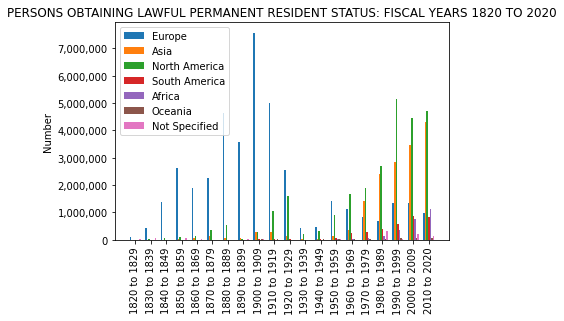

In [36]:
# Create plot of persons by continent

continent_data = df[(df['Region'] == 'Europe') | (df['Region'] == 'Asia') | (df['Region'] == 'America') | (df['Region'] == 'South America') | (df['Region'] == 'Africa') | (df['Region'] == 'Oceania') | (df['Region'] == 'Not Specified')]

labels = continent_data.iloc[:, 0].tolist()
europe_data = continent_data.iloc[0,1:].tolist()
asia_data = continent_data.iloc[1,1:].tolist()
america_data = continent_data.iloc[2,1:].tolist()
sa_data = continent_data.iloc[3,1:].tolist()
africa_data = continent_data.iloc[4,1:].tolist()
oceania_data = continent_data.iloc[5,1:].tolist()
other_data = continent_data.iloc[6,1:].tolist()

bar_labels = continent_data.columns.tolist()
bar_labels = bar_labels[1:]

x = np.arange(len(europe_data))
width = 0.1
fig, ax = plt.subplots()

europe_bars = ax.bar((x - (3 * width)), europe_data, width, label='Europe')
asia_bars = ax.bar((x - (2 * width)), asia_data, width, label='Asia')
america_bars = ax.bar((x - (1 * width)), america_data, width, label='North America')
sa_bars = ax.bar(x, sa_data, width, label='South America')
africa_bars = ax.bar((x + (1 * width)), africa_data, width, label='Africa')
oceania_bars = ax.bar((x + (2 * width)), oceania_data, width, label='Oceania')
other_bars = ax.bar((x + (3 * width)), other_data, width, label='Not Specified')

ax.set_xticks(x, bar_labels, rotation='vertical')
ax.set_ylabel('Number')
ax.set_title('PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020')
ax.legend()

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, a: format(int(x), ',')))

plt.show()

## Ancestry Data 2010-2020 5 year

In [120]:
# Load ancestry census data from 2020
# Import correct sheet in file
df_2020_5 = pd.read_csv('./data/5yr/2020_5yr.csv', skiprows=141, nrows = 27)
df_2020_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2020 = df_2020_5['Ancestry'][1:]
population_data_2020_5 = df_2020_5['Number'][1:]
df_2020_5.replace(',','', regex=True, inplace=True)
df_2020_5['Number'] = df_2020_5['Number'].astype(int)


# Load ancestry census data from 2019
# Import correct sheet in file
df_2019_5 = pd.read_csv('./data/5yr/2019_5yr.csv', skiprows=140, nrows = 27)
df_2019_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2019_5 = df_2019_5['Ancestry'][1:]
population_data_2019_5 = df_2019_5['Number'][1:]
df_2019_5.replace(',','', regex=True, inplace=True)
df_2019_5['Number'] = df_2019_5['Number'].astype(int)


# Load ancestry census data from 2018
# Import correct sheet in file
df_2018_5 = pd.read_csv('./data/5yr/2018_5yr.csv', skiprows=139, nrows = 27)
df_2018_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2018 = df_2018_5['Ancestry'][1:]
population_data_2018_5 = df_2018_5['Number'][1:]
df_2018_5.replace(',','', regex=True, inplace=True)
df_2018_5['Number'] = df_2018_5['Number'].astype(int)


# Load ancestry census data from 2017
# Import correct sheet in file
df_2017_5 = pd.read_csv('./data/5yr/2017_5yr.csv', skiprows=139, nrows = 27)
df_2017_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2017 = df_2017_5['Ancestry'][1:]
population_data_2017_5 = df_2017_5['Number'][1:]
df_2017_5.replace(',','', regex=True, inplace=True)
df_2017_5['Number'] = df_2017_5['Number'].astype(int)


# Load ancestry census data from 2016
# Import correct sheet in file
df_2016_5 = pd.read_csv('./data/5yr/2016_5yr.csv', skiprows=139, nrows = 27)
df_2016_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2016_5 = df_2016_5['Ancestry'][1:]
population_data_2016_5 = df_2016_5['Number'][1:]
df_2016_5.replace(',','', regex=True, inplace=True)
df_2016_5['Number'] = df_2016_5['Number'].astype(int)


# Load ancestry census data from 2015
# Import correct sheet in file
df_2015_5 = pd.read_csv('./data/5yr/2015_5yr.csv', skiprows=139, nrows = 27)
df_2015_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2015_5 = df_2015_5['Ancestry'][1:]
population_data_2015_5 = df_2015_5['Number'][1:]
df_2015_5.replace(',','', regex=True, inplace=True)
df_2015_5['Number'] = df_2015_5['Number'].astype(int)


# Load ancestry census data from 2014
# Import correct sheet in file
df_2014_5 = pd.read_csv('./data/5yr/2014_5yr.csv', skiprows=139, nrows = 27)
df_2014_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2014_5 = df_2014_5['Ancestry'][1:]
population_data_2014_5 = df_2014_5['Number'][1:]
df_2014_5.replace(',','', regex=True, inplace=True)
df_2014_5['Number'] = df_2014_5['Number'].astype(int)


# Load ancestry census data from 2013
# Import correct sheet in file
df_2013_5 = pd.read_csv('./data/5yr/2013_5yr.csv', skiprows=139, nrows = 27)
df_2013_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2013 = df_2013_5['Ancestry'][1:]
population_data_2013_5 = df_2013_5['Number'][1:]
df_2013_5.replace(',','', regex=True, inplace=True)
df_2013_5['Number'] = df_2013_5['Number'].astype(int)

# Load ancestry census data from 2012
# Import correct sheet in file
df_2012_5 = pd.read_csv('./data/5yr/2012_5yr.csv', skiprows=139, nrows = 27)
df_2012_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2012_5 = df_2012_5['Ancestry'][1:]
population_data_2012_5 = df_2012_5['Number'][1:]
df_2012_5.replace(',','', regex=True, inplace=True)
df_2012_5['Number'] = df_2012_5['Number'].astype(int)


# Load ancestry census data from 2011
# Import correct sheet in file
df_2011_5 = pd.read_csv('./data/5yr/2011_5yr.csv', skiprows=139, nrows = 27)
df_2011_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2011_5 = df_2011_5['Ancestry'][1:]
population_data_2011_5 = df_2011_5['Number'][1:]
df_2011_5.replace(',','', regex=True, inplace=True)
df_2011_5['Number'] = df_2011_5['Number'].astype(int)


# Load ancestry census data from 2010
# Import correct sheet in file
df_2010_5 = pd.read_csv('./data/5yr/2010_5yr.csv', skiprows=139, nrows = 27)
df_2010_5.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
# Rename column names
labels_2010_5 = df_2010_5['Ancestry'][1:]
population_data_2010_5 = df_2010_5['Number'][1:]
df_2010_5.replace(',','', regex=True, inplace=True)
df_2010_5['Number'] = df_2010_5['Number'].astype(int)


## Ancestry Data 2010-2019 1 year 

In [121]:
# Load ancestry census data from 2010 1yr
# Import correct sheet in file
df_2010_1 = pd.read_csv('./data/1yr/2010_1yr.csv', skiprows=139, nrows = 27)
df_2010_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2010_1 = df_2010_1['Ancestry'][1:]
population_data_2010_1 = df_2010_1['Number'][1:]
df_2010_1.replace(',','', regex=True, inplace=True)
df_2010_1['Number'] = df_2010_1['Number'].astype(int)


# Load ancestry census data from 2011 1yr
# Import correct sheet in file
df_2011_1 = pd.read_csv('./data/1yr/2011_1yr.csv', skiprows=139, nrows = 27)
df_2011_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2011 = df_2011_1['Ancestry'][1:]
population_data_2011_1 = df_2011_1['Number'][1:]
df_2011_1.replace(',','', regex=True, inplace=True)
df_2011_1['Number'] = df_2011_1['Number'].astype(int)


# Load ancestry census data from 2012 1yr
# Import correct sheet in file
df_2012_1 = pd.read_csv('./data/1yr/2012_1yr.csv', skiprows=139, nrows = 27)
df_2012_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2012 = df_2012_1['Ancestry'][1:]
population_data_2012_1 = df_2012_1['Number'][1:]
df_2012_1.replace(',','', regex=True, inplace=True)
df_2012_1['Number'] = df_2012_1['Number'].astype(int)


# Load ancestry census data from 2013 1yr
# Import correct sheet in file
df_2013_1 = pd.read_csv('./data/1yr/2013_1yr.csv', skiprows=139, nrows = 27)
df_2013_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2013_1 = df_2013_1['Ancestry'][1:]
population_data_2013_1 = df_2013_1['Number'][1:]
df_2013_1.replace(',','', regex=True, inplace=True)
df_2013_1['Number'] = df_2013_1['Number'].astype(int)


# Load ancestry census data from 2014 1yr
# Import correct sheet in file
df_2014_1 = pd.read_csv('./data/1yr/2014_1yr.csv', skiprows=139, nrows = 27)
df_2014_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2014_1 = df_2014_1['Ancestry'][1:]
population_data_2014_1 = df_2014_1['Number'][1:]
df_2014_1.replace(',','', regex=True, inplace=True)
df_2014_1['Number'] = df_2014_1['Number'].astype(int)


# Load ancestry census data from 2015 1yr
# Import correct sheet in file
df_2015_1 = pd.read_csv('./data/1yr/2015_1yr.csv', skiprows=139, nrows = 27)
df_2015_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2015_1 = df_2015_1['Ancestry'][1:]
population_data_2015_1 = df_2015_1['Number'][1:]
df_2015_1.replace(',','', regex=True, inplace=True)
df_2015_1['Number'] = df_2015_1['Number'].astype(int)


# Load ancestry census data from 2016 1yr
# Import correct sheet in file
df_2016_1 = pd.read_csv('./data/1yr/2016_1yr.csv', skiprows=139, nrows = 27)
df_2016_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2016_1 = df_2016_1['Ancestry'][1:]
population_data_2016_1 = df_2016_1['Number'][1:]
df_2016_1.replace(',','', regex=True, inplace=True)
df_2016_1['Number'] = df_2016_1['Number'].astype(int)


# Load ancestry census data from 2017 1yr
# Import correct sheet in file
df_2017_1 = pd.read_csv('./data/1yr/2017_1yr.csv', skiprows=139, nrows = 27)
df_2017_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2017_1 = df_2017_1['Ancestry'][1:]
population_data_2017_1 = df_2017_1['Number'][1:]
df_2017_1.replace(',','', regex=True, inplace=True)
df_2017_1['Number'] = df_2017_1['Number'].astype(int)


# Load ancestry census data from 2018 1yr
# Import correct sheet in file
df_2018_1 = pd.read_csv('./data/1yr/2018_1yr.csv', skiprows=139, nrows = 27)
df_2018_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2018_1 = df_2018_1['Ancestry'][1:]
population_data_2018_1 = df_2018_1['Number'][1:]
df_2018_1.replace(',','', regex=True, inplace=True)
df_2018_1['Number'] = df_2018_1['Number'].astype(int)


# Load ancestry census data from 2019 1yr
# Import correct sheet in file
df_2019_1 = pd.read_csv('./data/1yr/2019_1yr.csv', skiprows=140, nrows = 27)
df_2019_1.columns=['Ancestry', 'Number', 'Margin of Error', 'Percent', 'Percent Margin of Error']
labels_2019_1 = df_2019_1['Ancestry'][1:]
population_data_2019_1 = df_2019_1['Number'][1:]
df_2019_1.replace(',','', regex=True, inplace=True)
df_2019_1['Number'] = df_2019_1['Number'].astype(int)


## Aggregate 5 yr Dataframe and Graph

In [122]:
df_joined_5 = pd.DataFrame()
df_joined_5['Ancestry'] = df_2020_5['Ancestry']
df_joined_5['N_2010'] = df_2010_5['Number']
df_joined_5['N_2011'] = df_2011_5['Number']
df_joined_5['N_2012'] = df_2012_5['Number']
df_joined_5['N_2013'] = df_2013_5['Number']
df_joined_5['N_2014'] = df_2014_5['Number']
df_joined_5['N_2015'] = df_2015_5['Number']
df_joined_5['N_2016'] = df_2016_5['Number']
df_joined_5['N_2017'] = df_2017_5['Number']
df_joined_5['N_2018'] = df_2018_5['Number']
df_joined_5['N_2019'] = df_2019_5['Number']
df_joined_5['N_2020'] = df_2020_5['Number']
df_joined_5['Ancestry'] = df_joined_5['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T = df_joined_5.transpose()
df_joined_5_T = df_joined_5_T.rename(columns=df_joined_5_T.iloc[0])
df_joined_5_T.drop(index=df_joined_5_T.index[0], axis=0, inplace=True)
df_joined_5_T.columns = df_joined_5_T.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19094109,1517664,1595844,1453897,4950041,27403063,9326180,2138601,49836146,1337511,...,3072756,5227821,5821321,805282,2763624,4293208,1003505,956896,1922914,2516114
N_2011,19911467,1584874,1569839,1420962,4809836,26922124,9135933,2087970,49202203,1319128,...,3060143,5102732,5706263,786108,2828270,4211644,982909,958294,1888383,2586700
N_2012,20775461,1646808,1543224,1392161,4665736,26360639,8902996,2052405,48478298,1308335,...,3013959,3317115,5580121,769697,2886972,4155453,967123,960902,1861429,2646303
N_2013,21659006,1710927,1514919,1360858,4533617,25809471,8678917,2061608,47715461,1300818,...,2964169,3212402,5485459,754862,2931557,4067207,951617,958662,1821359,2698474
N_2014,22365250,1769645,1479588,1323182,4387814,25181294,8431568,2052979,46874293,1285866,...,2895600,3102082,5401397,735757,2987143,3984136,936806,963549,1779664,2756752
N_2015,22746991,1832106,1452344,1307381,4289116,24787018,8272538,2059482,46403053,1284473,...,2843400,3046005,5409343,725457,3119177,3933024,929291,973257,1778216,2824722
N_2016,21961129,1883456,1435359,1297738,4210787,24426623,8151499,2084903,45879360,1282655,...,2795443,3056848,5457798,714557,3232142,3908762,937376,986597,1805577,2881007
N_2017,21227906,1920562,1410576,1294689,4121110,23977180,7997196,2109242,45153215,1272806,...,2741864,3032134,5460745,700474,3402702,3847046,933084,995653,1805508,2932377
N_2018,20678613,1979363,1382835,1278457,4009279,23638645,7815721,2095503,44164758,1273100,...,2671995,3021077,5440934,688103,3589855,3788741,927539,1002367,1809314,2946905
N_2019,20266321,2009626,1358610,1265727,3872651,23493906,7606589,2074567,43038145,1265177,...,2608040,3011165,5398961,675728,3748931,3718915,921436,1009119,1851107,2985555


In [290]:
df_joined_5_fut = pd.DataFrame()
df_joined_5_fut['Ancestry'] = df_2020_5['Ancestry']
df_joined_5_fut['N_2010'] = df_2010_5['Number']
df_joined_5_fut['N_2011'] = df_2011_5['Number']
df_joined_5_fut['N_2012'] = df_2012_5['Number']
df_joined_5_fut['N_2013'] = df_2013_5['Number']
df_joined_5_fut['N_2014'] = df_2014_5['Number']
df_joined_5_fut['N_2015'] = df_2015_5['Number']
df_joined_5_fut['N_2016'] = df_2016_5['Number']
df_joined_5_fut['N_2017'] = df_2017_5['Number']
df_joined_5_fut['N_2018'] = df_2018_5['Number']
df_joined_5_fut['N_2019'] = df_2019_5['Number']
df_joined_5_fut['N_2020'] = df_2020_5['Number']
df_joined_5_fut['N_2021'] = 0
df_joined_5_fut['N_2022'] = 0
df_joined_5_fut['N_2023'] = 0
df_joined_5_fut['N_2024'] = 0
df_joined_5_fut['N_2025'] = 0

df_joined_5_fut['Ancestry'] = df_joined_5_fut['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T_fut = df_joined_5_fut.transpose()
df_joined_5_T_fut = df_joined_5_T_fut.rename(columns=df_joined_5_T_fut.iloc[0])
df_joined_5_T_fut.drop(index=df_joined_5_T_fut.index[0], axis=0, inplace=True)
df_joined_5_T_fut.columns = df_joined_5_T_fut.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_5_T_fut

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19094109,1517664,1595844,1453897,4950041,27403063,9326180,2138601,49836146,1337511,...,3072756,5227821,5821321,805282,2763624,4293208,1003505,956896,1922914,2516114
N_2011,19911467,1584874,1569839,1420962,4809836,26922124,9135933,2087970,49202203,1319128,...,3060143,5102732,5706263,786108,2828270,4211644,982909,958294,1888383,2586700
N_2012,20775461,1646808,1543224,1392161,4665736,26360639,8902996,2052405,48478298,1308335,...,3013959,3317115,5580121,769697,2886972,4155453,967123,960902,1861429,2646303
N_2013,21659006,1710927,1514919,1360858,4533617,25809471,8678917,2061608,47715461,1300818,...,2964169,3212402,5485459,754862,2931557,4067207,951617,958662,1821359,2698474
N_2014,22365250,1769645,1479588,1323182,4387814,25181294,8431568,2052979,46874293,1285866,...,2895600,3102082,5401397,735757,2987143,3984136,936806,963549,1779664,2756752
N_2015,22746991,1832106,1452344,1307381,4289116,24787018,8272538,2059482,46403053,1284473,...,2843400,3046005,5409343,725457,3119177,3933024,929291,973257,1778216,2824722
N_2016,21961129,1883456,1435359,1297738,4210787,24426623,8151499,2084903,45879360,1282655,...,2795443,3056848,5457798,714557,3232142,3908762,937376,986597,1805577,2881007
N_2017,21227906,1920562,1410576,1294689,4121110,23977180,7997196,2109242,45153215,1272806,...,2741864,3032134,5460745,700474,3402702,3847046,933084,995653,1805508,2932377
N_2018,20678613,1979363,1382835,1278457,4009279,23638645,7815721,2095503,44164758,1273100,...,2671995,3021077,5440934,688103,3589855,3788741,927539,1002367,1809314,2946905
N_2019,20266321,2009626,1358610,1265727,3872651,23493906,7606589,2074567,43038145,1265177,...,2608040,3011165,5398961,675728,3748931,3718915,921436,1009119,1851107,2985555


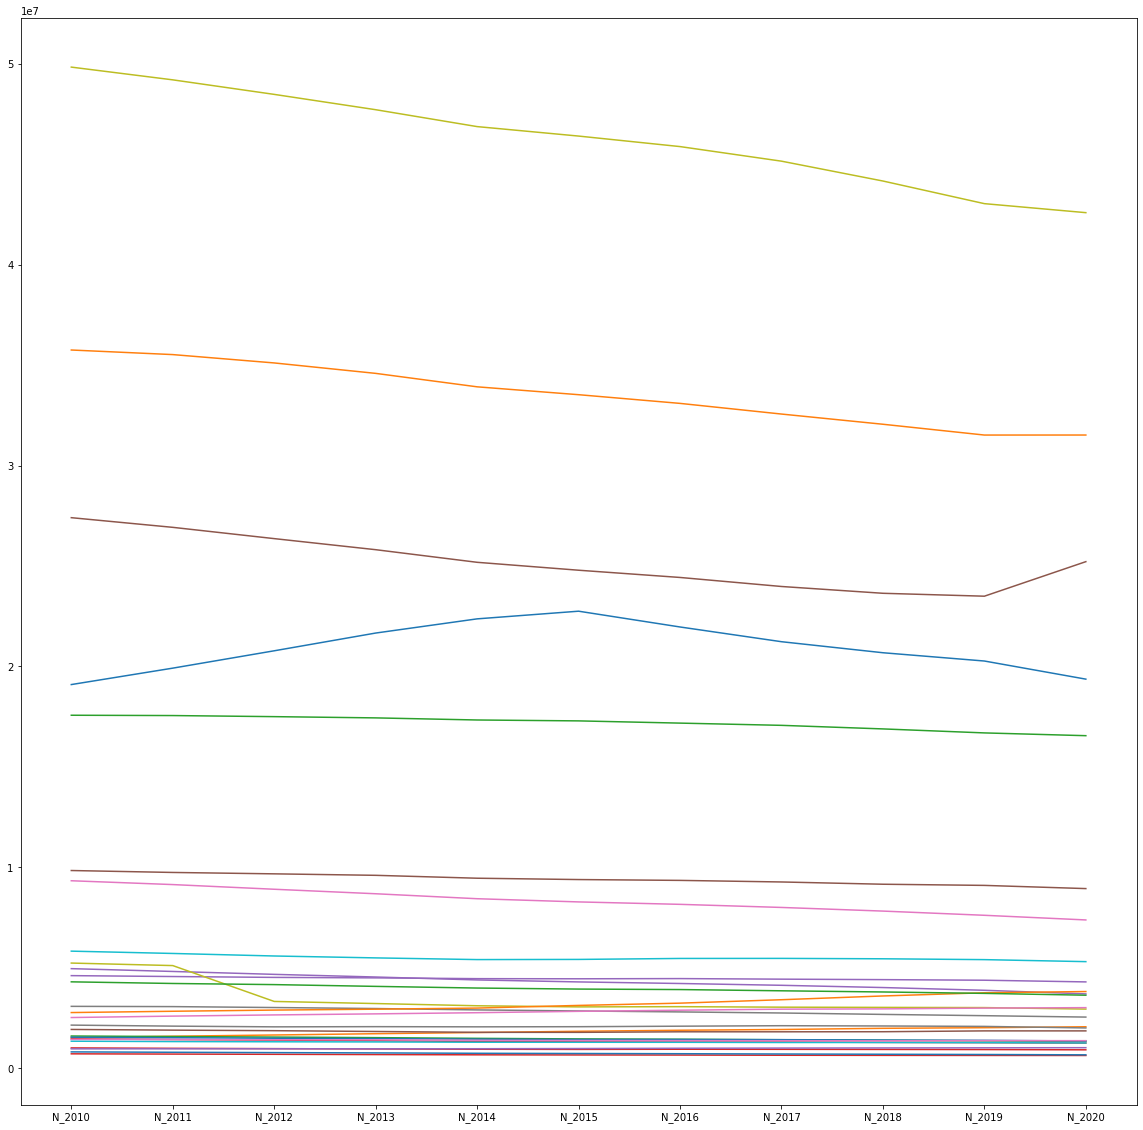

<Figure size 360x720 with 0 Axes>

In [123]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_joined_5_T)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend.png')
fig.savefig('./data/ancestry_line_graph/graph.png')

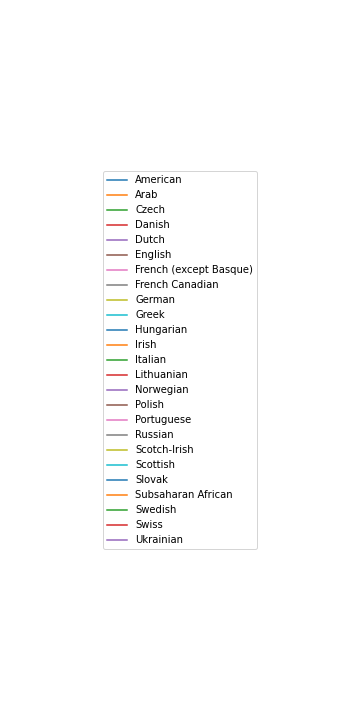

In [124]:
Image(filename = "./data/ancestry_line_graph/legend.png", width=500, height=500)

## Aggregate 1 yr Dataframe and Graph

In [309]:
df_joined_1 = pd.DataFrame()
df_joined_1['Ancestry'] = df_2010_1['Ancestry']
df_joined_1['N_2010'] = df_2010_1['Number']
df_joined_1['N_2011'] = df_2011_1['Number']
df_joined_1['N_2012'] = df_2012_1['Number']
df_joined_1['N_2013'] = df_2013_1['Number']
df_joined_1['N_2014'] = df_2014_1['Number']
df_joined_1['N_2015'] = df_2015_1['Number']
df_joined_1['N_2016'] = df_2016_1['Number']
df_joined_1['N_2017'] = df_2017_1['Number']
df_joined_1['N_2018'] = df_2018_1['Number']
df_joined_1['N_2019'] = df_2019_1['Number']

df_joined_1['Ancestry'] = df_joined_1['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T = df_joined_1.transpose()
df_joined_1_T = df_joined_1_T.rename(columns=df_joined_1_T.iloc[0])
df_joined_1_T.drop(index=df_joined_1_T.index[0], axis=0, inplace=True)
df_joined_1_T.columns = df_joined_1_T.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,2971599,3257161,5460679,762030,2789129,4088555,961380,939746,1793356,2624392
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,2994598,3143906,5412820,730373,2928281,4001651,916314,958470,1772511,2715539
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,2895912,3117627,5379735,742738,3008961,3980614,941692,968769,1780002,2758050
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,2844709,2976878,5310285,720203,3076544,3912522,917071,968754,1777162,2820776
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,2762830,2978827,5365154,706662,3223885,3887273,939268,984157,1757657,2865446
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,2723176,2981519,5510902,704601,3482384,3829029,915091,986698,1776955,2949716
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492,1898884,3019686
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636,1801259,3022676
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,2502911,2933199,5212119,654642,4015406,3614939,900022,996884,1804684,2949336
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874,1956225,3067240


In [310]:
df_joined_1_fut = pd.DataFrame()
df_joined_1_fut['Ancestry'] = df_2010_1['Ancestry']
df_joined_1_fut['N_2010'] = df_2010_1['Number']
df_joined_1_fut['N_2011'] = df_2011_1['Number']
df_joined_1_fut['N_2012'] = df_2012_1['Number']
df_joined_1_fut['N_2013'] = df_2013_1['Number']
df_joined_1_fut['N_2014'] = df_2014_1['Number']
df_joined_1_fut['N_2015'] = df_2015_1['Number']
df_joined_1_fut['N_2016'] = df_2016_1['Number']
df_joined_1_fut['N_2017'] = df_2017_1['Number']
df_joined_1_fut['N_2018'] = df_2018_1['Number']
df_joined_1_fut['N_2019'] = df_2019_1['Number']
df_joined_1_fut['N_2020'] = 0
df_joined_1_fut['N_2021'] = 0
df_joined_1_fut['N_2022'] = 0
df_joined_1_fut['N_2023'] = 0
df_joined_1_fut['N_2024'] = 0


df_joined_1_fut['Ancestry'] = df_joined_1_fut['Ancestry'].str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T_fut = df_joined_1_fut.transpose()
df_joined_1_T_fut = df_joined_1_T_fut.rename(columns=df_joined_1_T_fut.iloc[0])
df_joined_1_T_fut.drop(index=df_joined_1_T_fut.index[0], axis=0, inplace=True)
df_joined_1_T_fut.columns = df_joined_1_T_fut.columns.str.encode('ascii', 'ignore').str.decode('ascii')
df_joined_1_T_fut

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,2971599,3257161,5460679,762030,2789129,4088555,961380,939746,1793356,2624392
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,2994598,3143906,5412820,730373,2928281,4001651,916314,958470,1772511,2715539
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,2895912,3117627,5379735,742738,3008961,3980614,941692,968769,1780002,2758050
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,2844709,2976878,5310285,720203,3076544,3912522,917071,968754,1777162,2820776
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,2762830,2978827,5365154,706662,3223885,3887273,939268,984157,1757657,2865446
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,2723176,2981519,5510902,704601,3482384,3829029,915091,986698,1776955,2949716
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492,1898884,3019686
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636,1801259,3022676
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,2502911,2933199,5212119,654642,4015406,3614939,900022,996884,1804684,2949336
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874,1956225,3067240


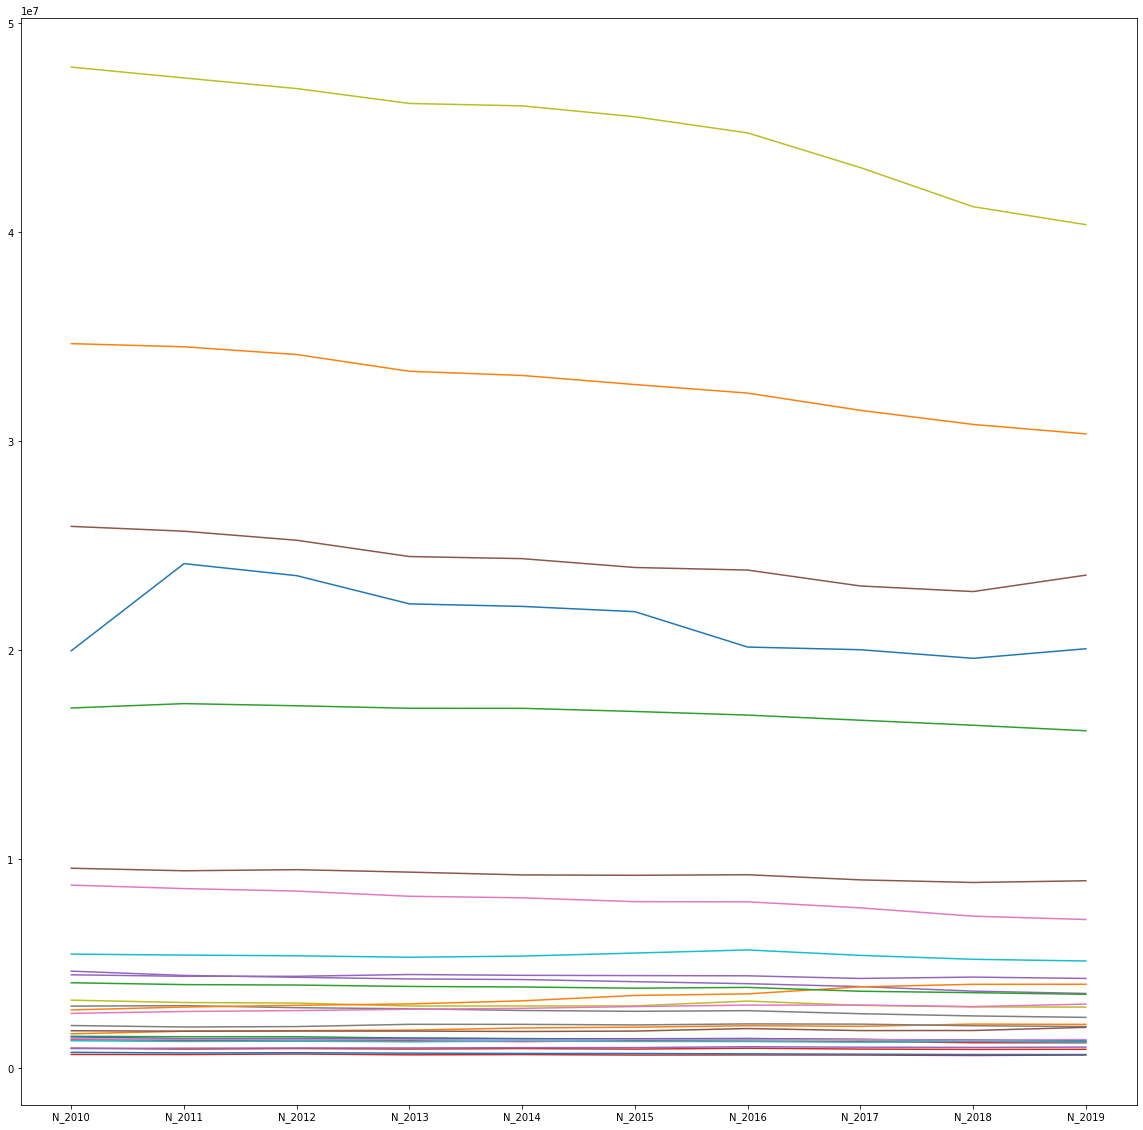

<Figure size 360x720 with 0 Axes>

In [225]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_joined_1_T)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend_1.png')
fig.savefig('./data/ancestry_line_graph/graph_1.png')

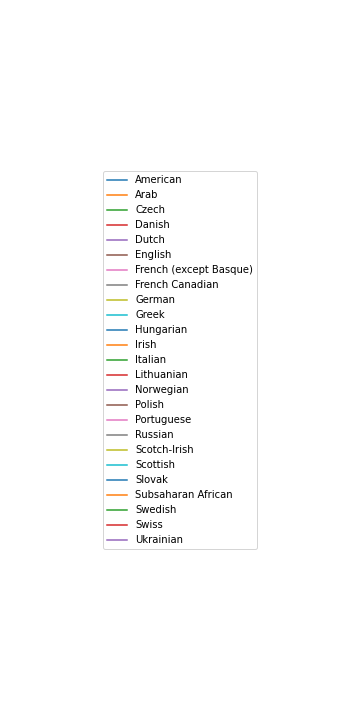

In [223]:
Image(filename = "./data/ancestry_line_graph/legend_1.png", width=500, height=500)

## Prediction Model Testing (1 year)

In [128]:
#train = pd.DataFrame(df_joined_1_T[df_joined_1_T.index < "N_2017"])
#test = pd.DataFrame(df_joined_1_T[df_joined_1_T.index >= "N_2017"])

# https://builtin.com/data-science/time-series-forecasting-python
# https://towardsdatascience.com/train-multiple-time-series-forecasting-models-in-one-line-of-python-code-615f2253b67a

train = df_joined_1_T[df_joined_1_T.index < "N_2017"]
test = df_joined_1_T[df_joined_1_T.index >= "N_2017"]


In [129]:
train

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,2971599,3257161,5460679,762030,2789129,4088555,961380,939746,1793356,2624392
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,2994598,3143906,5412820,730373,2928281,4001651,916314,958470,1772511,2715539
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,2895912,3117627,5379735,742738,3008961,3980614,941692,968769,1780002,2758050
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,2844709,2976878,5310285,720203,3076544,3912522,917071,968754,1777162,2820776
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,2762830,2978827,5365154,706662,3223885,3887273,939268,984157,1757657,2865446
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,2723176,2981519,5510902,704601,3482384,3829029,915091,986698,1776955,2949716
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492,1898884,3019686


In [130]:
test

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636,1801259,3022676
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,2502911,2933199,5212119,654642,4015406,3614939,900022,996884,1804684,2949336
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874,1956225,3067240


In [131]:
# df_train = df_joined_1[['Ancestry','N_2010', 'N_2011', 'N_2012', 'N_2013', 'N_2014', 'N_2015', 'N_2016']]
# df_test = df_joined_1[['Ancestry','N_2017', 'N_2018', 'N_2019']]


In [132]:
#model = auto_timeseries(forecast_period=219, score_type='rmse',
#                        time_interval='D', model_type = 'best')
#model.fit(traindata = df_train, ts_column="Date", target="Close")


In [133]:
AR_model = SARIMAX(train['American'].astype(float), order = (1, 0, 1))

In [134]:
AR_model = AR_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93081D+01    |proj g|=  5.62068D+01

At iterate    5    f=  1.83514D+01    |proj g|=  3.63750D-01

At iterate   10    f=  1.76880D+01    |proj g|=  1.66868D-02

At iterate   15    f=  1.76391D+01    |proj g|=  8.98939D-04

At iterate   20    f=  1.76339D+01    |proj g|=  4.90395D-05

           * * *

Tit   = total number of iterations


 This problem is unconstrained.


Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   7.842D-06   1.763D+01
  F =   17.633224667282786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [135]:
y_pred = AR_model.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = AR_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

In [136]:
y_pred_df

,lower American,upper American,Predictions
N_2017,1.720152e+07,1.999862e+07,1.860007e+07
N_2018,1.557931e+07,2.150524e+07,1.854228e+07
N_2019,1.454004e+07,2.242928e+07,1.848466e+07


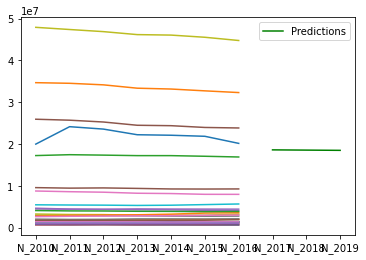

In [137]:
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [138]:
arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1377820.9568225741


RMSE:  288886.8631741374


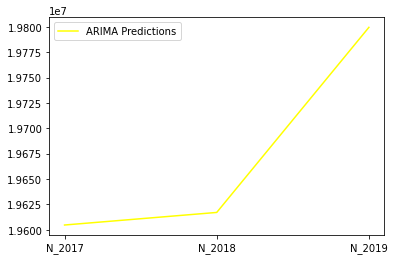

In [139]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [140]:
y_pred_df

,lower American,upper American,Predictions
N_2017,1.650773e+07,2.270186e+07,1.960479e+07
N_2018,1.472943e+07,2.450492e+07,1.961717e+07
N_2019,1.364734e+07,2.595170e+07,1.979952e+07


In [141]:
america_df = test['American']
america_df

N_2017    20024830
N_2018    19613477
N_2019    20071406
Name: American, dtype: object

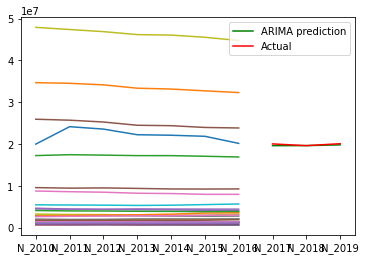

In [142]:
# See how ARIMA matches up with American ancestry data 2017-2019
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

In [143]:
sarimax_m = SARIMAX(train['American'].astype(float), order = (6, 1, 3), seasonal_order=(2,2,2,12))
sarimax_m = sarimax_m.fit()

y_pred = sarimax_m.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = sarimax_m.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index

sarimax_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ", sarimax_rmse)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE:  322707.02958669286


 This problem is unconstrained.


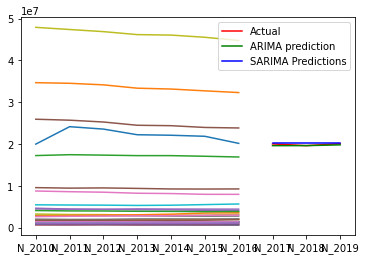

In [144]:
# See how SARIMA matches up with American ancestry data 2017-2019
plt.plot(train)

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

y_pred_out_sarima = y_pred_df["Predictions"] 
plt.plot(y_pred_out_sarima, color='Blue', label = 'SARIMA Predictions')
plt.legend()

Here, we can see that a model using ARIMA is better than a model using SARIMA for this specific problem. This makes sense, since this dataset contains values over entire years instead of smaller seasonal subsets of data.

In [145]:
### Experimentation with other models ###

# Imports, make classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
clf = KNeighborsClassifier(7)

# Create x
nationalities = len(train.iloc[0])
N_train = len(train.iloc[:,0])
N_test = len(test.iloc[:,0])

train_x = np.zeros((2, nationalities*N_train))
test_x = np.zeros((2, nationalities*N_test))
train_x = train.to_numpy().flatten()
test_x = test.to_numpy().flatten()

# Create y
train_y = []
test_y = []
for x in range(nationalities):
    for i in range(N_train):
        train_y.append(float(x))
    for i in range(N_test):
        test_y.append(float(x))

train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

# Normalize x 
# train_x_normalized = np.zeros((2, nationalities*N_train))
# test_x_normalized = np.zeros((2, nationalities*N_test))

# train_x_normalized /= np.mean(train_x[0])
# test_x_normalized /= np.mean(test_x[0])

# train_x_normalized = np.matrix(train_x_normalized).T
# test_x_normalized = np.matrix(test_x_normalized).T

train_x = np.matrix(train_x).T
test_x = np.matrix(test_x).T

# Fit model
clf.fit(train_x, train_y)

# Predict model
train_pred = clf.predict(train_x)
test_pred = clf.predict(test_x)

# Check accuracy
accuracy_train = accuracy_score(train_y, train_pred)
accuracy_test = accuracy_score(test_y, test_pred)

print("Training accuracy: ", accuracy_train)
print("Testing accuracy: ", accuracy_test)

Training accuracy:  0.15873015873015872
Testing accuracy:  0.037037037037037035


Creating a model like this does not make sense conceptually. Given our dataset and the problem that we are trying to solve, a method such as time series forecasting (see above) is more appropriate.

In [146]:
import warnings
warnings.filterwarnings('ignore')

## American

RMSE:  15779552.904636098


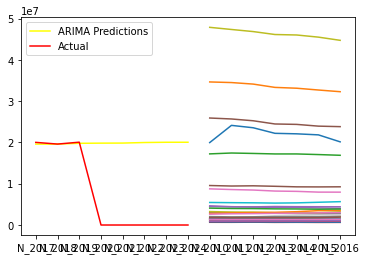

In [261]:
train = df_joined_1_T_fut[df_joined_1_T_fut.index < "N_2017"]
test = df_joined_1_T_fut[df_joined_1_T_fut.index >= "N_2017"]



# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_amer = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_amer = y_pred_amer.conf_int(alpha = 0.05) 
y_pred_df_amer["Predictions"] = ARIMAmodel.predict(start = y_pred_df_amer.index[0], end = y_pred_df_amer.index[-1])
y_pred_df_amer.index = test.index
y_pred_out_amer = y_pred_df_amer["Predictions"] 
plt.plot(y_pred_out_amer, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df_amer["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['American'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


In [262]:
test

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636,1801259,3022676
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,2502911,2933199,5212119,654642,4015406,3614939,900022,996884,1804684,2949336
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874,1956225,3067240
N_2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N_2021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N_2022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N_2023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N_2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Arab

RMSE:  1637191.6917914923


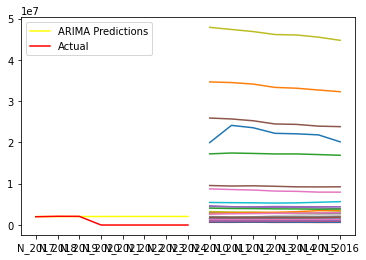

In [263]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Arab'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_arab = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_arab = y_pred_arab.conf_int(alpha = 0.05) 
y_pred_df_arab["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arab.index[0], end = y_pred_df_arab.index[-1])
y_pred_df_arab.index = test.index
y_pred_out_arab = y_pred_df_arab["Predictions"] 
plt.plot(y_pred_out_arab, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Arab"].values, y_pred_df_arab["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Arab'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Czech

RMSE:  1119747.8265153388


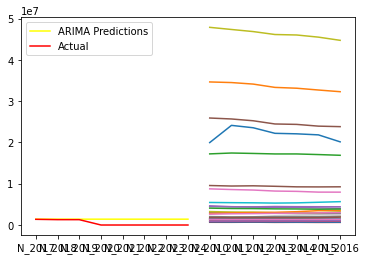

In [264]:

# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Czech'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_cz = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_cz = y_pred_cz.conf_int(alpha = 0.05) 
y_pred_df_cz["Predictions"] = ARIMAmodel.predict(start = y_pred_df_cz.index[0], end = y_pred_df_cz.index[-1])
y_pred_df_cz.index = test.index
y_pred_out_cz = y_pred_df_cz["Predictions"] 
plt.plot(y_pred_out_cz, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Czech"].values, y_pred_df_cz["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Czech'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Danish

RMSE:  1024712.6348616307


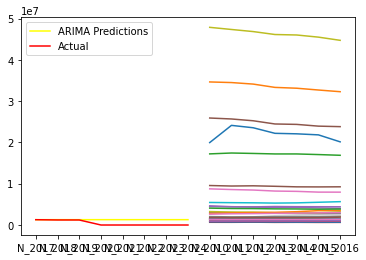

In [265]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Danish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_dan = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_dan = y_pred_dan.conf_int(alpha = 0.05) 
y_pred_df_dan["Predictions"] = ARIMAmodel.predict(start = y_pred_df_dan.index[0], end = y_pred_df_dan.index[-1])
y_pred_df_dan.index = test.index
y_pred_out_dan = y_pred_df_dan["Predictions"] 
plt.plot(y_pred_out_dan, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Danish"].values, y_pred_df_dan["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Danish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Dutch

RMSE:  3228034.3656460913


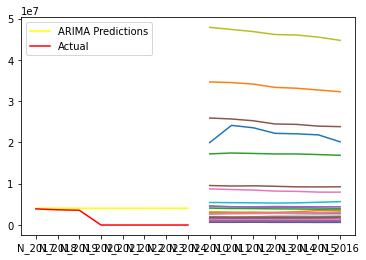

In [266]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Dutch'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_dut = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_dut = y_pred_dut.conf_int(alpha = 0.05) 
y_pred_df_dut["Predictions"] = ARIMAmodel.predict(start = y_pred_df_dut.index[0], end = y_pred_df_dut.index[-1])
y_pred_df_dut.index = test.index
y_pred_out_dut = y_pred_df_dut["Predictions"] 
plt.plot(y_pred_out_dut, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Dutch"].values, y_pred_df_dut["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Dutch'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## English

RMSE:  18898782.191852994


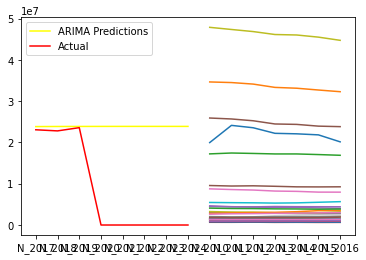

In [267]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['English'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_eng = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_eng = y_pred_eng.conf_int(alpha = 0.05) 
y_pred_df_eng["Predictions"] = ARIMAmodel.predict(start = y_pred_df_eng.index[0], end = y_pred_df_eng.index[-1])
y_pred_df_eng.index = test.index
y_pred_out_eng = y_pred_df_eng["Predictions"] 
plt.plot(y_pred_out_eng, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["English"].values, y_pred_df_eng["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['English'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## French (except Basque)

RMSE:  6327192.969566669


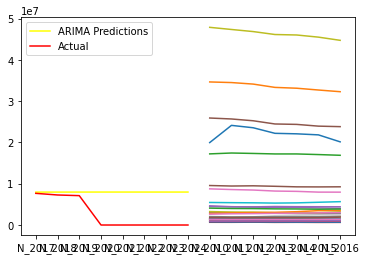

In [268]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['French (except Basque)'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_freb = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_freb = y_pred_freb.conf_int(alpha = 0.05) 
y_pred_df_freb["Predictions"] = ARIMAmodel.predict(start = y_pred_df_freb.index[0], end = y_pred_df_freb.index[-1])
y_pred_df_freb.index = test.index
y_pred_out_freb = y_pred_df_freb["Predictions"] 
plt.plot(y_pred_out_freb, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["French (except Basque)"].values, y_pred_df_freb["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['French (except Basque)'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## French Canadian

RMSE:  1676326.9042298018


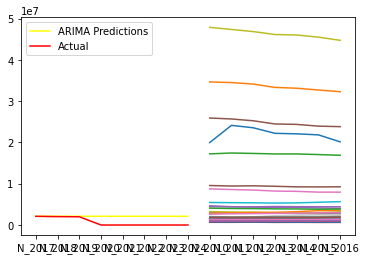

In [269]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['French Canadian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_fc = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_fc = y_pred_fc.conf_int(alpha = 0.05) 
y_pred_df_fc["Predictions"] = ARIMAmodel.predict(start = y_pred_df_fc.index[0], end = y_pred_df_fc.index[-1])
y_pred_df_fc.index = test.index
y_pred_out_fc = y_pred_df_fc["Predictions"] 
plt.plot(y_pred_out_fc, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["French Canadian"].values, y_pred_df_fc["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['French Canadian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## German

RMSE:  35522334.49993483


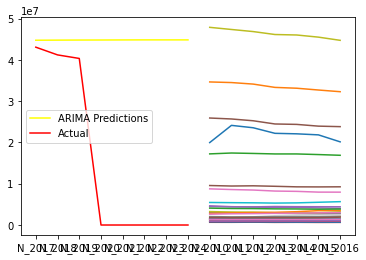

In [270]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['German'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ger = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ger = y_pred_ger.conf_int(alpha = 0.05) 
y_pred_df_ger["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ger.index[0], end = y_pred_df_ger.index[-1])
y_pred_df_ger.index = test.index
y_pred_out_ger = y_pred_df_ger["Predictions"] 
plt.plot(y_pred_out_ger, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["German"].values, y_pred_df_ger["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['German'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Greek

RMSE:  1010227.239739661


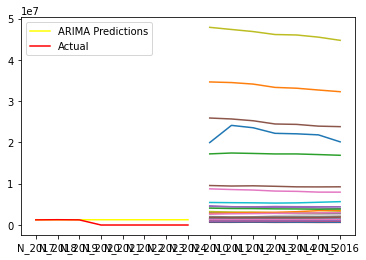

In [271]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Greek'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_grk = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_grk = y_pred_grk.conf_int(alpha = 0.05) 
y_pred_df_grk["Predictions"] = ARIMAmodel.predict(start = y_pred_df_grk.index[0], end = y_pred_df_grk.index[-1])
y_pred_df_grk.index = test.index
y_pred_out_grk = y_pred_df_grk["Predictions"] 
plt.plot(y_pred_out_grk, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Greek"].values, y_pred_df_grk["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Greek'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Hungarian

RMSE:  1126276.3924465294


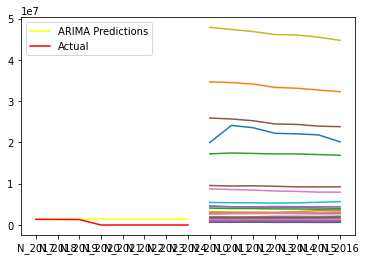

In [272]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Hungarian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_hun = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_hun = y_pred_hun.conf_int(alpha = 0.05) 
y_pred_df_hun["Predictions"] = ARIMAmodel.predict(start = y_pred_df_hun.index[0], end = y_pred_df_hun.index[-1])
y_pred_df_hun.index = test.index
y_pred_out_hun = y_pred_df_hun["Predictions"] 
plt.plot(y_pred_out_hun, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Hungarian"].values, y_pred_df_hun["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Hungarian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Irish

RMSE:  25620128.812181514


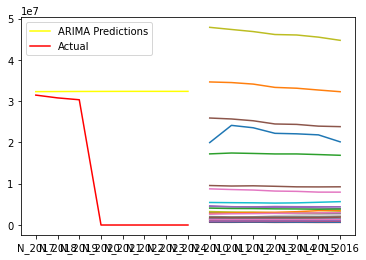

In [273]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Irish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_iri = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_iri = y_pred_iri.conf_int(alpha = 0.05) 
y_pred_df_iri["Predictions"] = ARIMAmodel.predict(start = y_pred_df_iri.index[0], end = y_pred_df_iri.index[-1])
y_pred_df_iri.index = test.index
y_pred_out_iri = y_pred_df_iri["Predictions"] 
plt.plot(y_pred_out_iri, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Irish"].values, y_pred_df_iri["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Irish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Italian

RMSE:  13368137.482837763


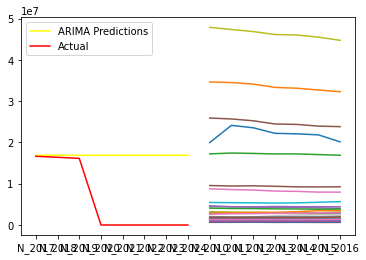

In [274]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Italian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ita = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ita = y_pred_ita.conf_int(alpha = 0.05) 
y_pred_df_ita["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ita.index[0], end = y_pred_df_ita.index[-1])
y_pred_df_ita.index = test.index
y_pred_out_ita = y_pred_df_ita["Predictions"] 
plt.plot(y_pred_out_ita, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Italian"].values, y_pred_df_ita["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Italian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Lithuanian

RMSE:  502072.08901545225


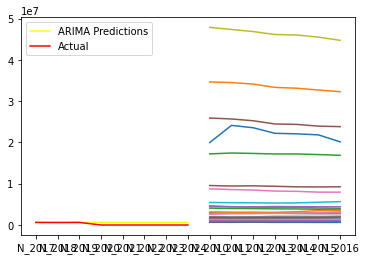

In [275]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Lithuanian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_lit = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_lit = y_pred_lit.conf_int(alpha = 0.05) 
y_pred_df_lit["Predictions"] = ARIMAmodel.predict(start = y_pred_df_lit.index[0], end = y_pred_df_lit.index[-1])
y_pred_df_lit.index = test.index
y_pred_out_lit = y_pred_df_lit["Predictions"] 
plt.plot(y_pred_out_lit, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Lithuanian"].values, y_pred_df_lit["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Lithuanian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Norwegian

RMSE:  3495961.882322474


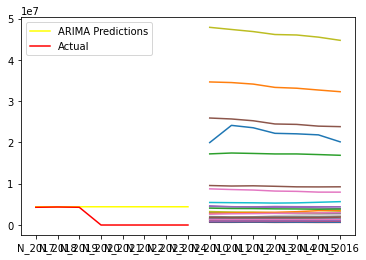

In [276]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Norwegian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_nor = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_nor = y_pred_nor.conf_int(alpha = 0.05) 
y_pred_df_nor["Predictions"] = ARIMAmodel.predict(start = y_pred_df_nor.index[0], end = y_pred_df_nor.index[-1])
y_pred_df_nor.index = test.index
y_pred_out_nor = y_pred_df_nor["Predictions"] 
plt.plot(y_pred_out_nor, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Norwegian"].values, y_pred_df_nor["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Norwegian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Polish

RMSE:  7324417.728307329


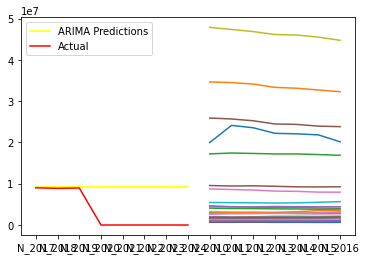

In [277]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Polish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_pol = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_pol = y_pred_pol.conf_int(alpha = 0.05) 
y_pred_df_pol["Predictions"] = ARIMAmodel.predict(start = y_pred_df_pol.index[0], end = y_pred_df_pol.index[-1])
y_pred_df_pol.index = test.index
y_pred_out_pol = y_pred_df_pol["Predictions"] 
plt.plot(y_pred_out_pol, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Polish"].values, y_pred_df_pol["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Polish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Portuguese

RMSE:  1087319.711526635


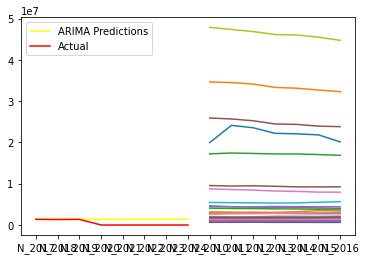

In [278]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Portuguese'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_port = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_port = y_pred_port.conf_int(alpha = 0.05) 
y_pred_df_port["Predictions"] = ARIMAmodel.predict(start = y_pred_df_port.index[0], end = y_pred_df_port.index[-1])
y_pred_df_port.index = test.index
y_pred_out_port = y_pred_df_port["Predictions"] 
plt.plot(y_pred_out_port, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Portuguese"].values, y_pred_df_port["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Portuguese'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Russian

RMSE:  2187765.9248075983


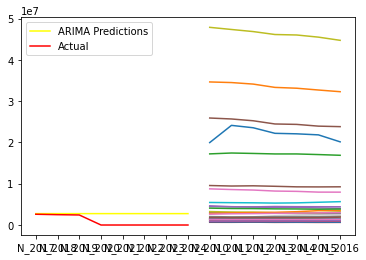

In [279]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Russian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_rus = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_rus = y_pred_rus.conf_int(alpha = 0.05) 
y_pred_df_rus["Predictions"] = ARIMAmodel.predict(start = y_pred_df_rus.index[0], end = y_pred_df_rus.index[-1])
y_pred_df_rus.index = test.index
y_pred_out_rus = y_pred_df_rus["Predictions"] 
plt.plot(y_pred_out_rus, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Russian"].values, y_pred_df_rus["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Russian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Scotch-irish

RMSE:  2528924.205931475


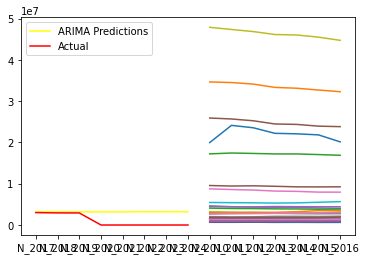

In [280]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Scotch-Irish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_sci = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_sci = y_pred_sci.conf_int(alpha = 0.05) 
y_pred_df_sci["Predictions"] = ARIMAmodel.predict(start = y_pred_df_sci.index[0], end = y_pred_df_sci.index[-1])
y_pred_df_sci.index = test.index
y_pred_out_sci = y_pred_df_sci["Predictions"] 
plt.plot(y_pred_out_sci, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Scotch-Irish"].values, y_pred_df_sci["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Scotch-Irish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Scottish

RMSE:  4487174.588622341


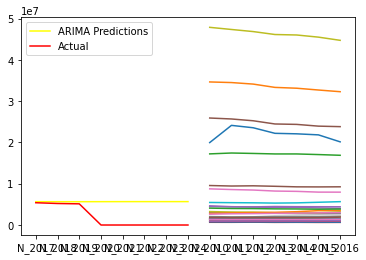

In [281]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Scottish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_sco = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_sco = y_pred_sco.conf_int(alpha = 0.05) 
y_pred_df_sco["Predictions"] = ARIMAmodel.predict(start = y_pred_df_sco.index[0], end = y_pred_df_sco.index[-1])
y_pred_df_sco.index = test.index
y_pred_out_sco = y_pred_df_sco["Predictions"] 
plt.plot(y_pred_out_sco, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Scottish"].values, y_pred_df_sco["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Scottish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Slovak

RMSE:  546313.4438286201


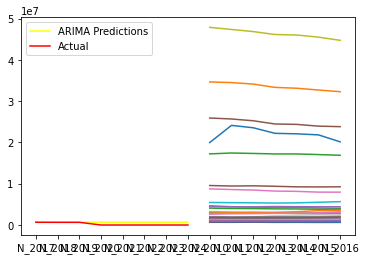

In [282]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Slovak'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_slo = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_slo = y_pred_slo.conf_int(alpha = 0.05) 
y_pred_df_slo["Predictions"] = ARIMAmodel.predict(start = y_pred_df_slo.index[0], end = y_pred_df_slo.index[-1])
y_pred_df_slo.index = test.index
y_pred_out_slo = y_pred_df_slo["Predictions"] 
plt.plot(y_pred_out_slo, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Slovak"].values, y_pred_df_slo["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Slovak'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Subsaharan African

RMSE:  2908965.147018385


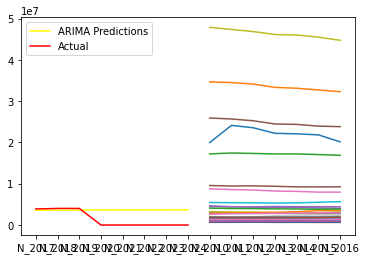

In [283]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Subsaharan African'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ssa = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ssa = y_pred_ssa.conf_int(alpha = 0.05) 
y_pred_df_ssa["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ssa.index[0], end = y_pred_df_ssa.index[-1])
y_pred_df_ssa.index = test.index
y_pred_out_ssa = y_pred_df_ssa["Predictions"] 
plt.plot(y_pred_out_ssa, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Subsaharan African"].values, y_pred_df_ssa["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Subsaharan African'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Swedish

RMSE:  3062156.923188032


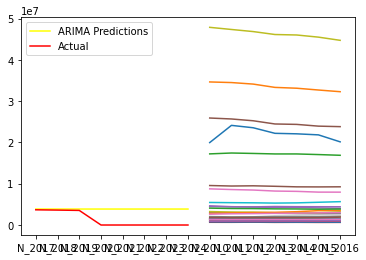

In [284]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Swedish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_swe = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_swe = y_pred_swe.conf_int(alpha = 0.05) 
y_pred_df_swe["Predictions"] = ARIMAmodel.predict(start = y_pred_df_swe.index[0], end = y_pred_df_swe.index[-1])
y_pred_df_swe.index = test.index
y_pred_out_swe = y_pred_df_swe["Predictions"] 
plt.plot(y_pred_out_swe, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Swedish"].values, y_pred_df_swe["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Swedish'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Swiss

RMSE:  755787.8503766762


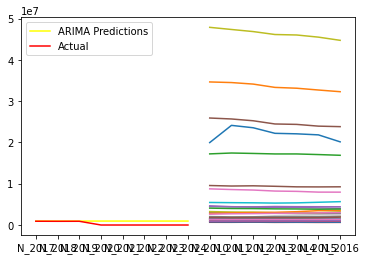

In [285]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Swiss'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_swi = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_swi = y_pred_swi.conf_int(alpha = 0.05) 
y_pred_df_swi["Predictions"] = ARIMAmodel.predict(start = y_pred_df_swi.index[0], end = y_pred_df_swi.index[-1])
y_pred_df_swi.index = test.index
y_pred_out_swi = y_pred_df_swi["Predictions"] 
plt.plot(y_pred_out_swi, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Swiss"].values, y_pred_df_swi["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Swiss'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Ukrainian

RMSE:  817169.2660453247


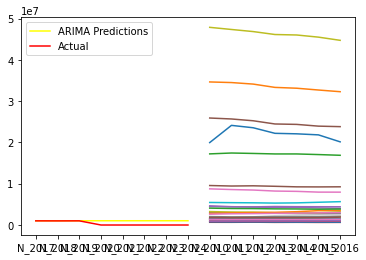

In [286]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Ukrainian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ukr = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ukr = y_pred_ukr.conf_int(alpha = 0.05) 
y_pred_df_ukr["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ukr.index[0], end = y_pred_df_ukr.index[-1])
y_pred_df_ukr.index = test.index
y_pred_out_ukr = y_pred_df_ukr["Predictions"] 
plt.plot(y_pred_out_ukr, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Ukrainian"].values, y_pred_df_ukr["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Ukrainian'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## Welsh

RMSE:  1504414.6334372484


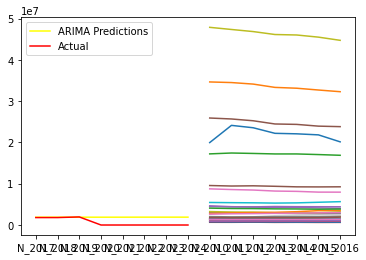

In [287]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Welsh'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_wel = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_wel = y_pred_wel.conf_int(alpha = 0.05) 
y_pred_df_wel["Predictions"] = ARIMAmodel.predict(start = y_pred_df_wel.index[0], end = y_pred_df_wel.index[-1])
y_pred_df_wel.index = test.index
y_pred_out_wel = y_pred_df_wel["Predictions"] 
plt.plot(y_pred_out_wel, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Welsh"].values, y_pred_df_wel["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['Welsh'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

## West Indian

RMSE:  2408616.2292046584


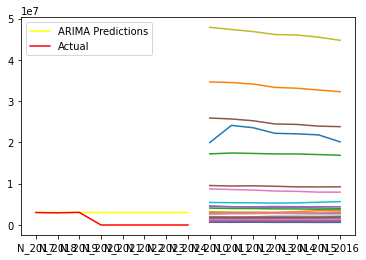

In [288]:
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['West Indian (excluding Hispanic origin groups)'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_wei = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_wei = y_pred_wei.conf_int(alpha = 0.05) 
y_pred_df_wei["Predictions"] = ARIMAmodel.predict(start = y_pred_df_wei.index[0], end = y_pred_df_wei.index[-1])
y_pred_df_wei.index = test.index
y_pred_out_wei = y_pred_df_wei["Predictions"] 
plt.plot(y_pred_out_wei, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["West Indian (excluding Hispanic origin groups)"].values, y_pred_df_wei["Predictions"]))
print("RMSE: ",arima_rmse)
plt.plot(train)

plt.plot(test['West Indian (excluding Hispanic origin groups)'], color='red', label = 'Actual')
plt.legend()

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

In [330]:
df_future_1= pd.DataFrame()
df_future_1["American"]=df_joined_1_T["American"].append(y_pred_out_amer.tail(6))
df_future_1["Arab"] =df_joined_1_T["Arab"].append(y_pred_out_arab.tail(6))
df_future_1["Czech"] =df_joined_1_T["Czech"].append(y_pred_out_cz.tail(6))
df_future_1["Danish"] =df_joined_1_T["Danish"].append(y_pred_out_dan.tail(6))
df_future_1["Dutch"] =df_joined_1_T["Dutch"].append(y_pred_out_dut.tail(6))
df_future_1["English"] =df_joined_1_T["English"].append(y_pred_out_eng.tail(6))
df_future_1["French (except Basque)"] =df_joined_1_T["French (except Basque)"].append(y_pred_out_freb.tail(6))
df_future_1["French Canadian"] =df_joined_1_T["French Canadian"].append(y_pred_out_fc.tail(6))
df_future_1["German"] =df_joined_1_T["German"].append(y_pred_out_ger.tail(6))
df_future_1["Greek"] =df_joined_1_T["Greek"].append(y_pred_out_grk.tail(6))
df_future_1["Hungarian"] =df_joined_1_T["Hungarian"].append(y_pred_out_hun.tail(6))
df_future_1["Irish"] =df_joined_1_T["Irish"].append(y_pred_out_iri.tail(6))
df_future_1["Italian"] =df_joined_1_T["Italian"].append(y_pred_out_ita.tail(6))
df_future_1["Lithuanian"] =df_joined_1_T["Lithuanian"].append(y_pred_out_lit.tail(6))
df_future_1["Norwegian"] =df_joined_1_T["Norwegian"].append(y_pred_out_nor.tail(6))
df_future_1["Polish"] =df_joined_1_T["Polish"].append(y_pred_out_pol.tail(6))
df_future_1["Portuguese"] =df_joined_1_T["Portuguese"].append(y_pred_out_port.tail(6))
df_future_1["Russian"] =df_joined_1_T["Russian"].append(y_pred_out_rus.tail(6))
df_future_1["Scotch-Irish"] =df_joined_1_T["Scotch-Irish"].append(y_pred_out_sci.tail(6))
df_future_1["Scottish"] =df_joined_1_T["Scottish"].append(y_pred_out_sco.tail(6))
df_future_1["Slovak"] =df_joined_1_T["Slovak"].append(y_pred_out_slo.tail(6))
df_future_1["Subsaharan African"] =df_joined_1_T["Subsaharan African"].append(y_pred_out_ssa.tail(6))
df_future_1["Swedish"] =df_joined_1_T["Swedish"].append(y_pred_out_swe.tail(6))
df_future_1["Swiss"] =df_joined_1_T["Swiss"].append(y_pred_out_swi.tail(6))
df_future_1["Ukrainian"] =df_joined_1_T["Ukrainian"].append(y_pred_out_ukr.tail(6))
df_future_1["Welsh"] =df_joined_1_T["Welsh"].append(y_pred_out_wel.tail(6))
df_future_1["West Indian (excluding Hispanic origin groups)"] =df_joined_1_T["West Indian (excluding Hispanic origin groups)"].append(y_pred_out_wei.tail(6))


In [331]:
df_future_1

,American,Arab,Czech,Danish,Dutch,English,French (except Basque),French Canadian,German,Greek,...,Russian,Scotch-Irish,Scottish,Slovak,Subsaharan African,Swedish,Swiss,Ukrainian,Welsh,West Indian (excluding Hispanic origin groups)
N_2010,19975875,1646371,1525187,1375506,4645131,25926451,8761496,2042808,47901779,1315775,...,2971599,3257161,5460679,762030,2789129,4088555,961380,939746,1793356,2624392
N_2011,24144605,1769251,1508360,1335678,4440324,25695922,8595793,1971979,47383539,1280777,...,2994598,3143906,5412820,730373,2928281,4001651,916314,958470,1772511,2715539
N_2012,23567147,1798991,1507815,1296751,4350633,25261814,8475331,1992174,46875013,1296119,...,2895912,3117627,5379735,742738,3008961,3980614,941692,968769,1780002,2758050
N_2013,22217931,1822511,1441072,1311484,4271869,24483225,8227938,2100842,46162557,1265072,...,2844709,2976878,5310285,720203,3076544,3912522,917071,968754,1777162,2820776
N_2014,22097012,1927432,1419630,1275222,4243067,24382182,8153515,2099430,46047113,1295703,...,2762830,2978827,5365154,706662,3223885,3887273,939268,984157,1757657,2865446
N_2015,21844951,1963478,1391020,1315302,4141375,23959441,7969633,2072053,45526331,1280897,...,2723176,2981519,5510902,704601,3482384,3829029,915091,986698,1776955,2949716
N_2016,20151829,2032892,1412051,1295169,4044507,23835787,7962052,2120016,44754050,1278174,...,2754205,3212692,5658914,687243,3557902,3867110,957460,1028492,1898884,3019686
N_2017,20024830,2005223,1379037,1284171,3906193,23074947,7673619,2110014,43093766,1246095,...,2608412,3007722,5399371,670681,3893865,3683020,916404,1006636,1801259,3022676
N_2018,19613477,2110727,1298652,1220506,3688602,22807283,7275203,2032630,41222462,1284153,...,2502911,2933199,5212119,654642,4015406,3614939,900022,996884,1804684,2949336
N_2019,20071406,2097642,1294789,1215809,3577936,23593434,7116099,1994739,40363511,1247142,...,2432733,2924654,5131171,654150,4018144,3536320,905079,1009874,1956225,3067240


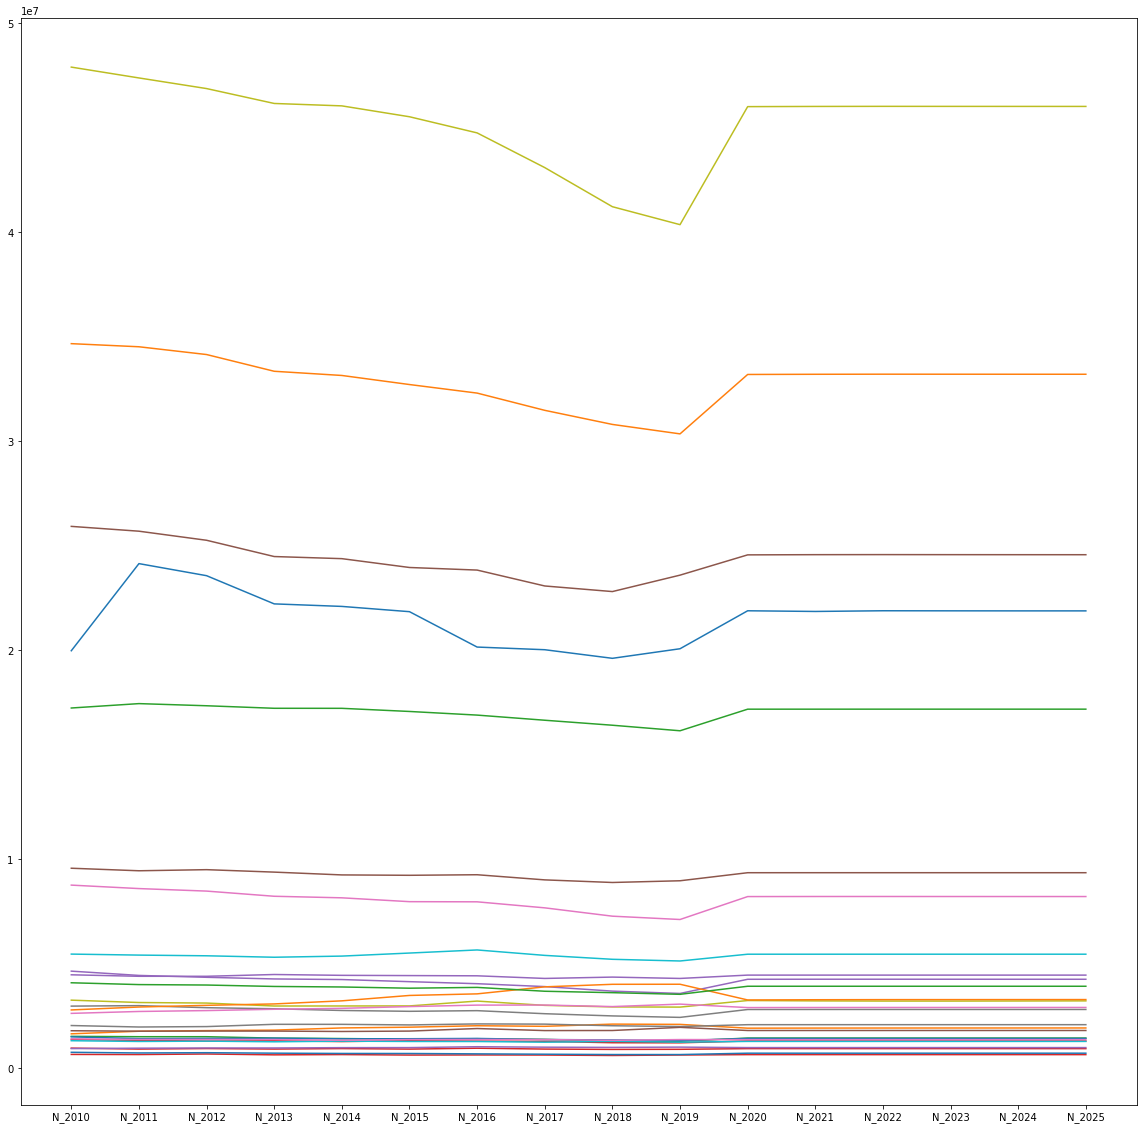

<Figure size 360x720 with 0 Axes>

In [345]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_future_1)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend_1_fut.png')
fig.savefig('./data/ancestry_line_graph/graph_1_fut.png')

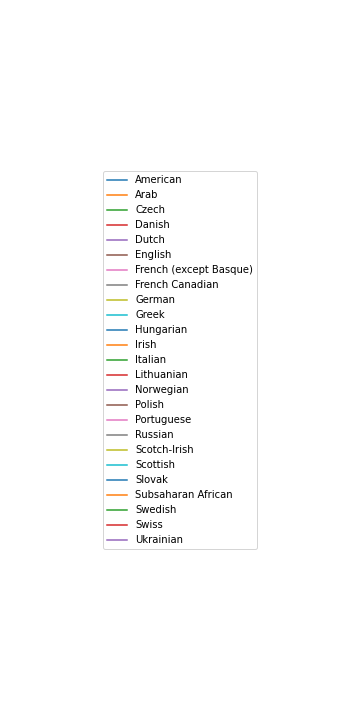

In [346]:
Image(filename = "./data/ancestry_line_graph/legend_1_fut.png", width=500, height=500)

## Prediction Model Testing (5 year)

In [66]:
train = df_joined_5_T[df_joined_5_T.index < "N_2017"]
test = df_joined_5_T[df_joined_5_T.index >= "N_2017"]

In [67]:
print(test.columns)

Index(['American', 'Arab', 'Czech', 'Danish', 'Dutch', 'English',
       'French (except Basque)', 'French Canadian', 'German', 'Greek',
       'Hungarian', 'Irish', 'Italian', 'Lithuanian', 'Norwegian', 'Polish',
       'Portuguese', 'Russian', 'Scotch-Irish', 'Scottish', 'Slovak',
       'Subsaharan African', 'Swedish', 'Swiss', 'Ukrainian'],
      dtype='object')


RMSE:  868808.4238388268


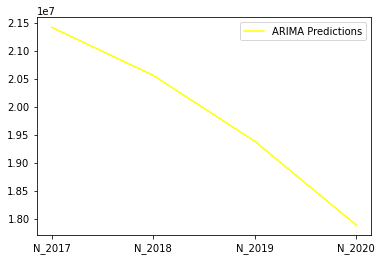

In [68]:
# Use ARIMA again
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 3, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [69]:
america_df = test['American']
america_df

N_2017    21227906
N_2018    20678613
N_2019    20266321
N_2020    19364103
Name: American, dtype: object

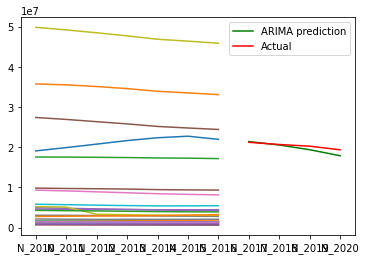

In [70]:
# See how ARIMA model predicts
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(america_df, color='red', label = 'Actual')
plt.legend()

## 5 year predictions


American RMSE:  16346894.012018971
Arab RMSE:  1435508.014846795
Czech RMSE:  1077107.7174312475
Danish RMSE:  972177.2476966224
Dutch RMSE:  3182331.9373874874
English RMSE:  18323124.964377217
French RMSE:  6134937.63671114
French Canadian RMSE:  1553285.211078339
German RMSE:  34341799.8309364
Greek RMSE:  956510.9313236104
Hungarian RMSE:  1063217.4500880432
Irish RMSE:  24766288.748058293
Italian RMSE:  12808927.573188534
Lithuanian RMSE:  485140.3928744433
Norwegian RMSE:  3321458.1241415297
Polish RMSE:  6975282.286280271
Portuguese RMSE:  1020297.9004056121
Russian RMSE:  2098896.2758636954
Scotch Irish RMSE:  2403890.193322151
Scottish RMSE:  4066827.248296611
Slovak RMSE:  536840.4816454554
SubSaharan africa RMSE:  2461749.0418439885
Swedish RMSE:  2926094.532028962
Swiss RMSE:  699027.1009212111
Ukrainian RMSE:  736119.547441572
Welsh RMSE:  1345537.3200321451
West Indian RMSE:  2167033.750015747


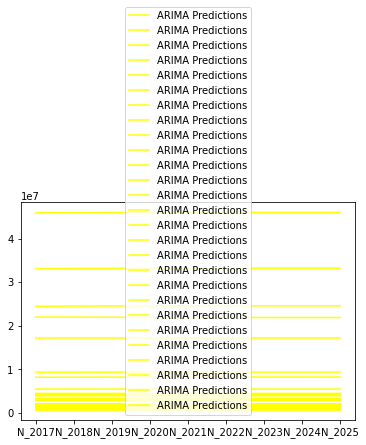

In [333]:
train = df_joined_5_T_fut[df_joined_5_T_fut.index < "N_2017"]
test = df_joined_5_T_fut[df_joined_5_T_fut.index >= "N_2017"]

test["2021"]=""
test["2022"]=""
test["2023"]=""
test["2024"]=""
test["2025"]=""
#American
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['American'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_amer = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_amer = y_pred_amer.conf_int(alpha = 0.05) 
y_pred_df_amer["Predictions"] = ARIMAmodel.predict(start = y_pred_df_amer.index[0], end = y_pred_df_amer.index[-1])
y_pred_df_amer.index = test.index
y_pred_out_amer = y_pred_df_amer["Predictions"] 
plt.plot(y_pred_out_amer, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["American"].values, y_pred_df_amer["Predictions"]))
print("American RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Arab
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Arab'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_arab = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_arab = y_pred_arab.conf_int(alpha = 0.05) 
y_pred_df_arab["Predictions"] = ARIMAmodel.predict(start = y_pred_df_arab.index[0], end = y_pred_df_arab.index[-1])
y_pred_df_arab.index = test.index
y_pred_out_arab = y_pred_df_arab["Predictions"] 
plt.plot(y_pred_out_arab, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Arab"].values, y_pred_df_arab["Predictions"]))
print("Arab RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

#Czech
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Czech'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_cz = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_cz = y_pred_cz.conf_int(alpha = 0.05) 
y_pred_df_cz["Predictions"] = ARIMAmodel.predict(start = y_pred_df_cz.index[0], end = y_pred_df_cz.index[-1])
y_pred_df_cz.index = test.index
y_pred_out_cz = y_pred_df_cz["Predictions"] 
plt.plot(y_pred_out_cz, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Czech"].values, y_pred_df_cz["Predictions"]))
print("Czech RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')
# Danish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Danish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_dan = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_dan = y_pred_dan.conf_int(alpha = 0.05) 
y_pred_df_dan["Predictions"] = ARIMAmodel.predict(start = y_pred_df_dan.index[0], end = y_pred_df_dan.index[-1])
y_pred_df_dan.index = test.index
y_pred_out_dan = y_pred_df_dan["Predictions"] 
plt.plot(y_pred_out_dan, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Danish"].values, y_pred_df_dan["Predictions"]))
print("Danish RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


#Dutch
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Dutch'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_dut = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_dut = y_pred_dut.conf_int(alpha = 0.05) 
y_pred_df_dut["Predictions"] = ARIMAmodel.predict(start = y_pred_df_dut.index[0], end = y_pred_df_dut.index[-1])
y_pred_df_dut.index = test.index
y_pred_out_dut = y_pred_df_dut["Predictions"] 
plt.plot(y_pred_out_dut, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Dutch"].values, y_pred_df_dut["Predictions"]))
print("Dutch RMSE: ",arima_rmse)

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


#English
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['English'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_eng = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_eng = y_pred_eng.conf_int(alpha = 0.05) 
y_pred_df_eng["Predictions"] = ARIMAmodel.predict(start = y_pred_df_eng.index[0], end = y_pred_df_eng.index[-1])
y_pred_df_eng.index = test.index
y_pred_out_eng = y_pred_df_eng["Predictions"] 
plt.plot(y_pred_out_eng, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["English"].values, y_pred_df_eng["Predictions"]))
print("English RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# French Except Basque
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['French (except Basque)'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_freb = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_freb = y_pred_freb.conf_int(alpha = 0.05) 
y_pred_df_freb["Predictions"] = ARIMAmodel.predict(start = y_pred_df_freb.index[0], end = y_pred_df_freb.index[-1])
y_pred_df_freb.index = test.index
y_pred_out_freb = y_pred_df_freb["Predictions"] 
plt.plot(y_pred_out_freb, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["French (except Basque)"].values, y_pred_df_freb["Predictions"]))
print("French RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# French Canadian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['French Canadian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_fc = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_fc = y_pred_fc.conf_int(alpha = 0.05) 
y_pred_df_fc["Predictions"] = ARIMAmodel.predict(start = y_pred_df_fc.index[0], end = y_pred_df_fc.index[-1])
y_pred_df_fc.index = test.index
y_pred_out_fc = y_pred_df_fc["Predictions"] 
plt.plot(y_pred_out_fc, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["French Canadian"].values, y_pred_df_fc["Predictions"]))
print("French Canadian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

#German
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['German'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ger = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ger = y_pred_ger.conf_int(alpha = 0.05) 
y_pred_df_ger["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ger.index[0], end = y_pred_df_ger.index[-1])
y_pred_df_ger.index = test.index
y_pred_out_ger = y_pred_df_ger["Predictions"] 
plt.plot(y_pred_out_ger, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["German"].values, y_pred_df_ger["Predictions"]))
print("German RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Greek
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Greek'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_grk = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_grk = y_pred_grk.conf_int(alpha = 0.05) 
y_pred_df_grk["Predictions"] = ARIMAmodel.predict(start = y_pred_df_grk.index[0], end = y_pred_df_grk.index[-1])
y_pred_df_grk.index = test.index
y_pred_out_grk = y_pred_df_grk["Predictions"] 
plt.plot(y_pred_out_grk, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Greek"].values, y_pred_df_grk["Predictions"]))
print("Greek RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Hungarian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Hungarian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_hun = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_hun = y_pred_hun.conf_int(alpha = 0.05) 
y_pred_df_hun["Predictions"] = ARIMAmodel.predict(start = y_pred_df_hun.index[0], end = y_pred_df_hun.index[-1])
y_pred_df_hun.index = test.index
y_pred_out_hun = y_pred_df_hun["Predictions"] 
plt.plot(y_pred_out_hun, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Hungarian"].values, y_pred_df_hun["Predictions"]))
print("Hungarian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


#Irish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Irish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_iri = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_iri = y_pred_iri.conf_int(alpha = 0.05) 
y_pred_df_iri["Predictions"] = ARIMAmodel.predict(start = y_pred_df_iri.index[0], end = y_pred_df_iri.index[-1])
y_pred_df_iri.index = test.index
y_pred_out_iri = y_pred_df_iri["Predictions"] 
plt.plot(y_pred_out_iri, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Irish"].values, y_pred_df_iri["Predictions"]))
print("Irish RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# Italian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Italian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ita = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ita = y_pred_ita.conf_int(alpha = 0.05) 
y_pred_df_ita["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ita.index[0], end = y_pred_df_ita.index[-1])
y_pred_df_ita.index = test.index
y_pred_out_ita = y_pred_df_ita["Predictions"] 
plt.plot(y_pred_out_ita, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Italian"].values, y_pred_df_ita["Predictions"]))
print("Italian RMSE: ",arima_rmse)

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

#Lithuanian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Lithuanian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_lit = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_lit = y_pred_lit.conf_int(alpha = 0.05) 
y_pred_df_lit["Predictions"] = ARIMAmodel.predict(start = y_pred_df_lit.index[0], end = y_pred_df_lit.index[-1])
y_pred_df_lit.index = test.index
y_pred_out_lit = y_pred_df_lit["Predictions"] 
plt.plot(y_pred_out_lit, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Lithuanian"].values, y_pred_df_lit["Predictions"]))
print("Lithuanian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# Norwegian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Norwegian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_nor = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_nor = y_pred_nor.conf_int(alpha = 0.05) 
y_pred_df_nor["Predictions"] = ARIMAmodel.predict(start = y_pred_df_nor.index[0], end = y_pred_df_nor.index[-1])
y_pred_df_nor.index = test.index
y_pred_out_nor = y_pred_df_nor["Predictions"] 
plt.plot(y_pred_out_nor, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Norwegian"].values, y_pred_df_nor["Predictions"]))
print("Norwegian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# Polish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Polish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_pol = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_pol = y_pred_pol.conf_int(alpha = 0.05) 
y_pred_df_pol["Predictions"] = ARIMAmodel.predict(start = y_pred_df_pol.index[0], end = y_pred_df_pol.index[-1])
y_pred_df_pol.index = test.index
y_pred_out_pol = y_pred_df_pol["Predictions"] 
plt.plot(y_pred_out_pol, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Polish"].values, y_pred_df_pol["Predictions"]))
print("Polish RMSE: ",arima_rmse)

#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# Portuguese
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Portuguese'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_port = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_port = y_pred_port.conf_int(alpha = 0.05) 
y_pred_df_port["Predictions"] = ARIMAmodel.predict(start = y_pred_df_port.index[0], end = y_pred_df_port.index[-1])
y_pred_df_port.index = test.index
y_pred_out_port = y_pred_df_port["Predictions"] 
plt.plot(y_pred_out_port, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Portuguese"].values, y_pred_df_port["Predictions"]))
print("Portuguese RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

#Russian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Russian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_rus = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_rus = y_pred_rus.conf_int(alpha = 0.05) 
y_pred_df_rus["Predictions"] = ARIMAmodel.predict(start = y_pred_df_rus.index[0], end = y_pred_df_rus.index[-1])
y_pred_df_rus.index = test.index
y_pred_out_rus = y_pred_df_rus["Predictions"] 
plt.plot(y_pred_out_rus, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Russian"].values, y_pred_df_rus["Predictions"]))
print("Russian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

#Scotch-irish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Scotch-Irish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_sci = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_sci = y_pred_sci.conf_int(alpha = 0.05) 
y_pred_df_sci["Predictions"] = ARIMAmodel.predict(start = y_pred_df_sci.index[0], end = y_pred_df_sci.index[-1])
y_pred_df_sci.index = test.index
y_pred_out_sci = y_pred_df_sci["Predictions"] 
plt.plot(y_pred_out_sci, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Scotch-Irish"].values, y_pred_df_sci["Predictions"]))
print("Scotch Irish RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')


# Scottish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Scottish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_sco = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_sco = y_pred_sco.conf_int(alpha = 0.05) 
y_pred_df_sco["Predictions"] = ARIMAmodel.predict(start = y_pred_df_sco.index[0], end = y_pred_df_sco.index[-1])
y_pred_df_sco.index = test.index
y_pred_out_sco = y_pred_df_sco["Predictions"] 
plt.plot(y_pred_out_sco, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Scottish"].values, y_pred_df_sco["Predictions"]))
print("Scottish RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Slovak
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Slovak'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_slo = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_slo = y_pred_slo.conf_int(alpha = 0.05) 
y_pred_df_slo["Predictions"] = ARIMAmodel.predict(start = y_pred_df_slo.index[0], end = y_pred_df_slo.index[-1])
y_pred_df_slo.index = test.index
y_pred_out_slo = y_pred_df_slo["Predictions"] 
plt.plot(y_pred_out_slo, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Slovak"].values, y_pred_df_slo["Predictions"]))
print("Slovak RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Subsaharan Africa
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Subsaharan African'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ssa = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ssa = y_pred_ssa.conf_int(alpha = 0.05) 
y_pred_df_ssa["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ssa.index[0], end = y_pred_df_ssa.index[-1])
y_pred_df_ssa.index = test.index
y_pred_out_ssa = y_pred_df_ssa["Predictions"] 
plt.plot(y_pred_out_ssa, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Subsaharan African"].values, y_pred_df_ssa["Predictions"]))
print("SubSaharan africa RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Swedish
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Swedish'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_swe = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_swe = y_pred_swe.conf_int(alpha = 0.05) 
y_pred_df_swe["Predictions"] = ARIMAmodel.predict(start = y_pred_df_swe.index[0], end = y_pred_df_swe.index[-1])
y_pred_df_swe.index = test.index
y_pred_out_swe = y_pred_df_swe["Predictions"] 
plt.plot(y_pred_out_swe, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Swedish"].values, y_pred_df_swe["Predictions"]))
print("Swedish RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Swiss
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Swiss'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_swi = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_swi = y_pred_swi.conf_int(alpha = 0.05) 
y_pred_df_swi["Predictions"] = ARIMAmodel.predict(start = y_pred_df_swi.index[0], end = y_pred_df_swi.index[-1])
y_pred_df_swi.index = test.index
y_pred_out_swi = y_pred_df_swi["Predictions"] 
plt.plot(y_pred_out_swi, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Swiss"].values, y_pred_df_swi["Predictions"]))
print("Swiss RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')
# Urkainian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Ukrainian'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_ukr = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_ukr = y_pred_ukr.conf_int(alpha = 0.05) 
y_pred_df_ukr["Predictions"] = ARIMAmodel.predict(start = y_pred_df_ukr.index[0], end = y_pred_df_ukr.index[-1])
y_pred_df_ukr.index = test.index
y_pred_out_ukr = y_pred_df_ukr["Predictions"] 
plt.plot(y_pred_out_ukr, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Ukrainian"].values, y_pred_df_ukr["Predictions"]))
print("Ukrainian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# Welsh
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['Welsh'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_wel = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_wel = y_pred_wel.conf_int(alpha = 0.05) 
y_pred_df_wel["Predictions"] = ARIMAmodel.predict(start = y_pred_df_wel.index[0], end = y_pred_df_wel.index[-1])
y_pred_df_wel.index = test.index
y_pred_out_wel = y_pred_df_wel["Predictions"] 
plt.plot(y_pred_out_wel, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["Welsh"].values, y_pred_df_wel["Predictions"]))
print("Welsh RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

# West Indian
# Adjust ARIMA (Autoregressive Integrated Moving Average) model based on results
ARIMAmodel = ARIMA(train['West Indian (excluding Hispanic origin groups)'].astype(float), order = (6, 1, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred_wei = ARIMAmodel.get_forecast(len(test.index))
y_pred_df_wei = y_pred_wei.conf_int(alpha = 0.05) 
y_pred_df_wei["Predictions"] = ARIMAmodel.predict(start = y_pred_df_wei.index[0], end = y_pred_df_wei.index[-1])
y_pred_df_wei.index = test.index
y_pred_out_wei = y_pred_df_wei["Predictions"] 
plt.plot(y_pred_out_wei, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["West Indian (excluding Hispanic origin groups)"].values, y_pred_df_wei["Predictions"]))
print("West Indian RMSE: ",arima_rmse)


#plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

In [338]:
y_pred_out_amer.tail(5)


N_2021    2.185571e+07
N_2022    2.188915e+07
N_2023    2.188573e+07
N_2024    2.188351e+07
N_2025    2.188350e+07
Name: Predictions, dtype: float64

In [349]:
df_future_5= pd.DataFrame()
df_future_5["American"]=df_joined_5_T["American"].append(y_pred_out_amer.tail(5))
df_future_5["Arab"] =df_joined_5_T["Arab"].append(y_pred_out_arab.tail(5))
df_future_5["Czech"] =df_joined_5_T["Czech"].append(y_pred_out_cz.tail(5))
df_future_5["Danish"] =df_joined_5_T["Danish"].append(y_pred_out_dan.tail(5))
df_future_5["Dutch"] =df_joined_5_T["Dutch"].append(y_pred_out_dut.tail(5))
df_future_5["English"] =df_joined_5_T["English"].append(y_pred_out_eng.tail(5))
df_future_5["French (except Basque)"] =df_joined_5_T["French (except Basque)"].append(y_pred_out_freb.tail(5))
df_future_5["French Canadian"] =df_joined_5_T["French Canadian"].append(y_pred_out_fc.tail(5))
df_future_5["German"] =df_joined_5_T["German"].append(y_pred_out_ger.tail(5))
df_future_5["Greek"] =df_joined_5_T["Greek"].append(y_pred_out_grk.tail(5))
df_future_5["Hungarian"] =df_joined_5_T["Hungarian"].append(y_pred_out_hun.tail(5))
df_future_5["Irish"] =df_joined_5_T["Irish"].append(y_pred_out_iri.tail(5))
df_future_5["Italian"] =df_joined_5_T["Italian"].append(y_pred_out_ita.tail(5))
df_future_5["Lithuanian"] =df_joined_5_T["Lithuanian"].append(y_pred_out_lit.tail(5))
df_future_5["Norwegian"] =df_joined_5_T["Norwegian"].append(y_pred_out_nor.tail(5))
df_future_5["Polish"] =df_joined_5_T["Polish"].append(y_pred_out_pol.tail(5))
df_future_5["Portuguese"] =df_joined_5_T["Portuguese"].append(y_pred_out_port.tail(5))
df_future_5["Russian"] =df_joined_5_T["Russian"].append(y_pred_out_rus.tail(5))
df_future_5["Scotch-Irish"] =df_joined_5_T["Scotch-Irish"].append(y_pred_out_sci.tail(5))
df_future_5["Scottish"] =df_joined_5_T["Scottish"].append(y_pred_out_sco.tail(5))
df_future_5["Slovak"] =df_joined_5_T["Slovak"].append(y_pred_out_slo.tail(5))
df_future_5["Subsaharan African"] =df_joined_5_T["Subsaharan African"].append(y_pred_out_ssa.tail(5))
df_future_5["Swedish"] =df_joined_5_T["Swedish"].append(y_pred_out_swe.tail(5))
df_future_5["Swiss"] =df_joined_5_T["Swiss"].append(y_pred_out_swi.tail(5))
df_future_5["Ukrainian"] =df_joined_5_T["Ukrainian"].append(y_pred_out_ukr.tail(5))
df_future_5["Welsh"] =df_joined_5_T["Welsh"].append(y_pred_out_wel.tail(5))
df_future_5["West Indian (excluding Hispanic origin groups)"] =df_joined_1_T["West Indian (excluding Hispanic origin groups)"].append(y_pred_out_wei.tail(5))



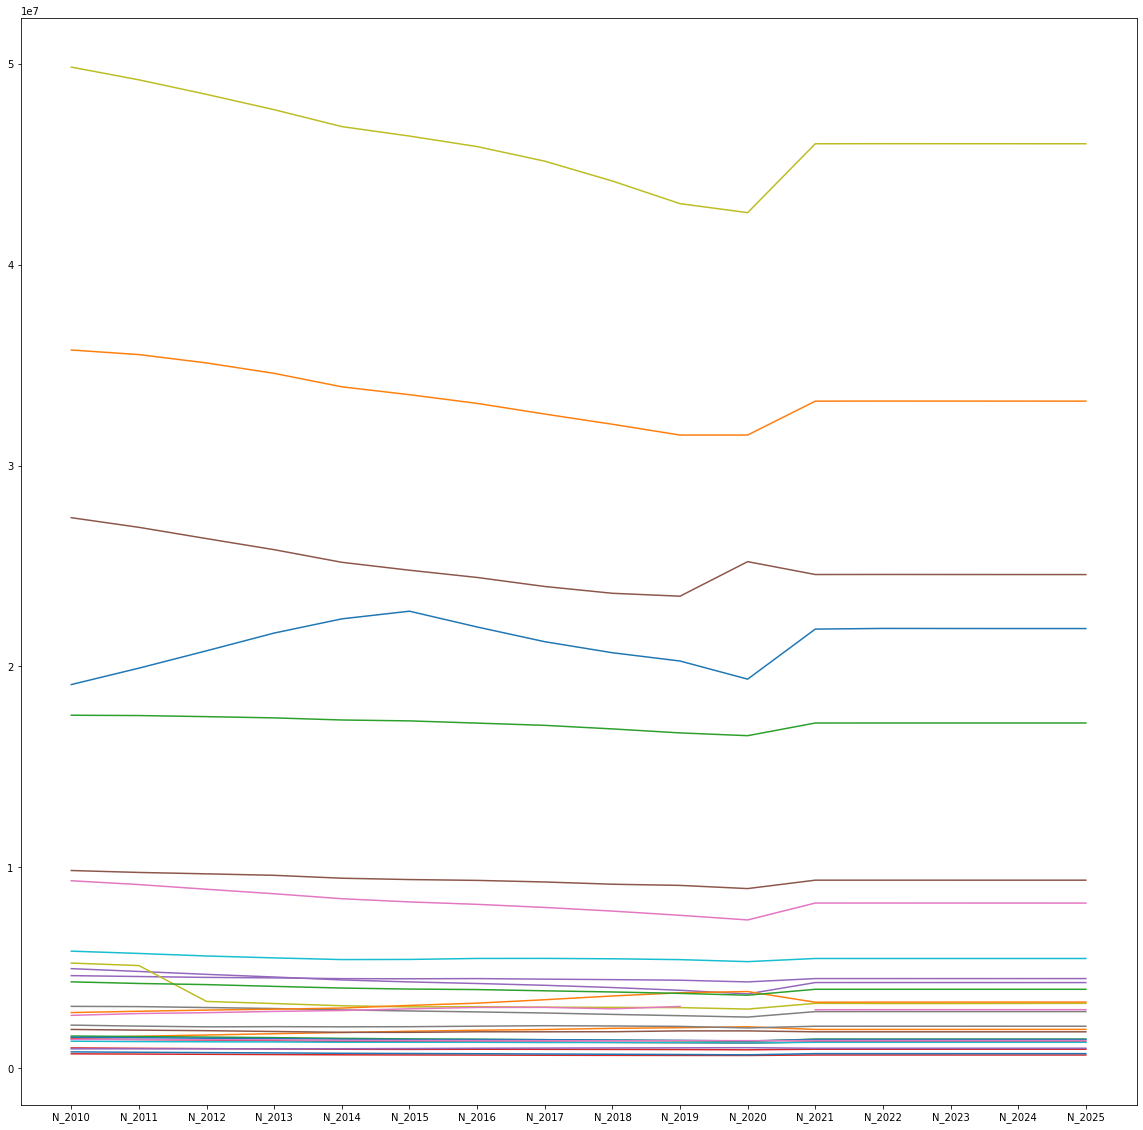

<Figure size 360x720 with 0 Axes>

In [350]:
fig = pylab.figure(figsize = (20,20))
figlegend = pylab.figure(figsize=(5,10))
ax = fig.add_subplot(111)
lines = ax.plot(df_future_5)
figlegend.legend(lines, ('American', 'Arab','Czech','Danish','Dutch','English','French (except Basque)',
                         'French Canadian','German','Greek','Hungarian', 'Irish', 'Italian','Lithuanian',
                         'Norwegian','Polish','Portuguese','Russian','Scotch-Irish','Scottish','Slovak',
                         'Subsaharan African','Swedish','Swiss','Ukrainian'), 'center')

figlegend.savefig('./data/ancestry_line_graph/legend_5_fut.png')
fig.savefig('./data/ancestry_line_graph/graph_5_fut.png')

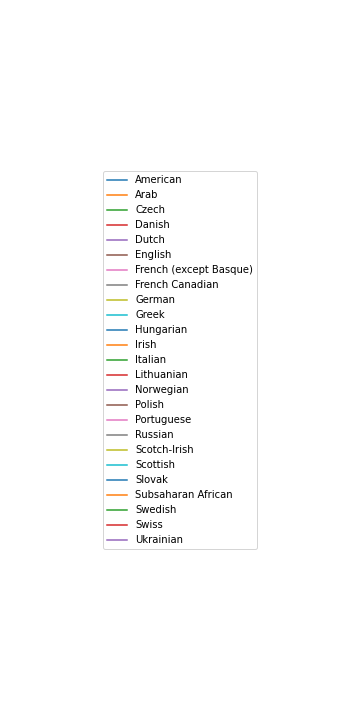

In [351]:
Image(filename = "./data/ancestry_line_graph/legend_5_fut.png", width=500, height=500)

# Prediction Model Testing (Immigration Data 1820-2020)

In [183]:
# Preprocessing

# Load Lawful Permanent Residents 2020 Supplementary Data Tables

# Title: PERSONS OBTAINING LAWFUL PERMANENT RESIDENT STATUS: FISCAL YEARS 1820 TO 2020
lawful2020_table2_in = pd.read_excel(directory + "fy2020_table2.xlsx", skiprows=3, nrows=88)
df = lawful2020_table2_in

# Make sure all column names are strings (2020 label saved as int)
df = df.rename(columns={2020:'2020'})

# Rename a column
df = df.rename(columns={"Region and country of last residence1": "Region"})

# Rename a row element
df.iloc[87]['Region'] = 'Not Specified'

# Replace NaN with 0, replace dashes with 0
df = df.fillna(0)
df.loc[:, df.columns != 'Region'] = df.loc[:, df.columns != 'Region'].replace('-',0, regex=True)

# Combine 2010-2019 and 2020 columns
df['2010 to 2020'] = df['2010 to 2019'] + df['2020']

# Remove a column
df = df.drop('2010 to 2019', axis=1)
df = df.drop('2020', axis=1)

In [72]:
# Check the columns (for train/test split)
df.columns

Index(['Region', '1820 to 1829', '1830 to 1839', '1840 to 1849',
       '1850 to 1859', '1860 to 1869', '1870 to 1879', '1880 to 1889',
       '1890 to 1899', '1900 to 1909', '1910 to 1919', '1920 to 1929',
       '1930 to 1939', '1940 to 1949', '1950 to 1959', '1960 to 1969',
       '1970 to 1979', '1980 to 1989', '1990 to 1999', '2000 to 2009',
       '2010 to 2020'],
      dtype='object')

In [73]:
train = df[df.columns[1:18]] # 1820-1829 to 1980-1989
test = df[df.columns[18:20]] # 1990-1999 to 2010-2020

In [74]:
df_1990 = test['1990 to 1999']

RMSE:  1264663.8620053502


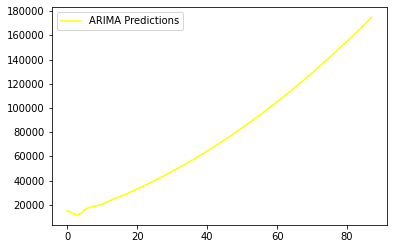

In [75]:
# Use ARIMA again
ARIMAmodel = ARIMA(train['1820 to 1829'].astype(float), order = (6, 3, 3))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test['1990 to 1999'].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

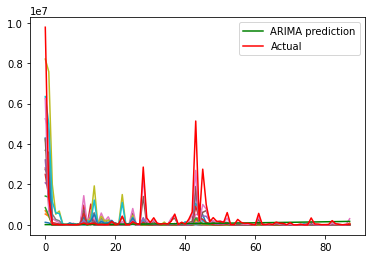

In [76]:
# See how ARIMA model predicts
plt.plot(train)
plt.plot(y_pred_out, color='green', label = 'ARIMA prediction')

plt.plot(df_1990, color='red', label = 'Actual')
plt.legend()

In [341]:
df

,Region,1820 to 1829,1830 to 1839,1840 to 1849,1850 to 1859,1860 to 1869,1870 to 1879,1880 to 1889,1890 to 1899,1900 to 1909,...,1920 to 1929,1930 to 1939,1940 to 1949,1950 to 1959,1960 to 1969,1970 to 1979,1980 to 1989,1990 to 1999,2000 to 2009,2010 to 2020
0,Total,128502,538381,1427337,2814554,2081261,2742137,5248568,3694294,8202388,...,4295510,699375,856608,2499268,3213749,4248203,6244379,9775398,10299430,11340808
1,Europe,99618,422853,1369423,2622617,1880389,2252050,4638684,3576411,7572569,...,2560340,444404,472524,1404973,1133443,826327,669694,1349219,1349609,977100
2,"Austria-Hungary2,3",0,0,0,0,3375,60127,314787,534059,2001376,...,60891,13902,13677,113015,27590,20387,20437,27529,33929,31371
3,"Austria2,3",0,0,0,0,2700,54529,204805,268218,532416,...,31392,6678,8496,81354,17571,14239,15374,18234,21151,20729
4,"Hungary2,3",0,0,0,0,483,5598,109982,203350,685567,...,29499,7224,5181,31661,10019,6148,5063,9295,12778,10642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Oceania,2,1,3,110,107,9094,7341,3279,11677,...,9860,3240,14262,11319,23659,39983,41432,56800,65793,64411
84,Australia20,2,1,2,104,96,8933,7250,3098,11191,...,8404,2260,11201,8275,14986,18708,16901,24288,32728,38242
85,New Zealand20,0,0,0,2,6,39,21,12,0,...,935,790,2351,1799,3775,5018,6129,8600,12495,10331
86,Other Oceania,0,0,1,4,5,122,70,169,486,...,521,190,710,1245,4898,16257,18402,23912,20570,15838
